#### 포함하는 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from multipledispatch import dispatch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#### 함수 정의

In [2]:
# 진행 상태 표시용 출력 함수 정의
def progressBar(progress, length, startTime = None):
    """
    진행 상태 표시
    1.0을 입력해야 로딩 표시 끝.
    progress : 0.0 ~ 1.0
    length : 로딩 바 길이
    """
    if progress < 1.0:
        if progress > 0:
            timeLeft = datetime.timedelta(seconds = int((time.time() - startTime) / progress * (1 - progress)))
        else:
            timeLeft = "0:00:00"
        progress = int(progress * length)
        print(f"\r{'■' * progress}{'□' * (length - progress)} {timeLeft}", end = " ")
    else:
        print(f"\r{'■' * length}")

In [3]:
# 문자열 데이터 컬럼의 유니크 확인 함수 정의
def getUnique(data):
    """문자열 데이터 컬럼의 유니크 확인"""
    for i in data.columns:
        if data[i].dtype == object:
            print(f"{i}\n{data[i].unique()}\n")

In [4]:
# 인코딩 함수 정의
@dispatch(object, list, list)
def orderedEncoding(data, columns, order):
    """문자열을 0에서 1사이 값으로 인코딩. 타겟 컬럼과 데이터 순서를 리스트로 전달."""
    
    # 리스트 길이
    dataLen = len(data)
    columnsLen = len(columns)
    orderLen = len(order) - 1

    # 시작 시간
    startTime = time.time()

    # 인코딩하 하는 리스트만큼 반복
    i = 0
    while i < columnsLen:

        # 데이터 길이만큼 반복
        j = 0
        while j < dataLen:

            # 진행 상태 표시
            progressBar((i * dataLen + j) / (columnsLen * dataLen), 100, startTime)

            # 타겟 인덱스
            tarIn = data.iloc[j]

            # 데이터 값만큼 반복
            k = 0
            while k <= orderLen:

                # 값의 순서에 따라 포함 여부 확인
                if order[k] in tarIn[columns[i]]:
                    data.loc[tarIn.name, columns[i]] = k / orderLen
                    break
                k += 1
            j += 1
            
        # 타입 변경
        data[columns[i]] = data[columns[i]].astype(float)
        i += 1
    progressBar(1, 100)

In [5]:
# 인코딩 함수 정의. 함수 오버로딩.
@dispatch(object, object)
def orderedEncoding(data, targetOrder):
    """문자열을 0에서 1사이 값으로 인코딩. 타겟 컬럼과 데이터 순서를 딕셔너리로 전달. { '컬럼' : ['데이터1', '데이터2', ...] }"""
    
    # 데이터 길이
    targets = targetOrder.keys()
    dataLen = len(data)
    targetLen = len(targets)

    # 시작 시간
    startTime = time.time()

    # 전체 데이터를 순회
    i = 0
    while i < dataLen:

        # 진행 상황 출력
        progressBar(i / dataLen, 100, startTime)

        # 타겟 인덱스
        tarIn = data.iloc[i]
        
        # 타겟 컬럼 순회
        for target in targets:

            # 데이터 값만큼 반복
            orderLen = len(targetOrder[target]) - 1
            k = 0
            while k <= orderLen:

                # 값의 순서에 따라 포함 여부 확인
                if targetOrder[target][k] in tarIn[target]:
                    data.loc[tarIn.name, target] = k / orderLen
                    break
                k += 1
        i += 1

    # 타입 변경
    for target in targets:
        data[target] = data[target].astype(float)

    # 진행 상활 출력
    progressBar(1, 100)

In [6]:
# 정답 데이터 인코딩 함수 정의
def answerEncoding(data, column, negative):
    """정답 데이터 인코딩. 0번 인덱스는 음성, 나머지 인덱스는 양성."""
    
    # 리스트 길이
    dataLen = len(data)

    # 시작 시간
    startTime = time.time()

    # 데이터 길이만큼 반복
    i = 0
    while i < dataLen:

        # 진행 상태 표시
        progressBar(i / dataLen, 100, startTime)

        # 타겟 인덱스
        tarIn = data.iloc[i]
        
        # 값의 순서에 따라 포함 여부 확인
        if negative in tarIn[column]:
            data.loc[tarIn.name, column] = 0
        else:
            data.loc[tarIn.name, column] = 1
            
        i += 1

    # 타입 변경
    data[column] = data[column].astype(int)
    progressBar(1, 100)

In [7]:
# 이상치 확인용 그래프 그리는 함수 정의
def drawBoxPlot(data):
    """이상치 확인용 그래프 그리기"""

    # 확인할 컬럼 담을 리스트
    columns = []

    # 수치 데이터 컬럼만 선별
    for i in data.columns:
        if data[i].dtype != object:
            columns.append(i)

    # 표를 그리기 위한 변수
    length = len(columns)
    height = length // 2 + 1

    # 그리기
    plt.style.use(['dark_background'])
    plt.figure(figsize = (12, 4 * height))
    
    i = 0
    while i < length:
        plt.subplot(height, 2, i + 1)
        sns.boxplot(x = data[columns[i]])
        i += 1
        
    plt.show()

In [8]:
# 이상치 수정하는 함수 정의
def fixValues(data, columns):
    """이상치를 정상치의 끝으로 수정"""
    for i in columns:
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        data.loc[lower > data[i], i] = lower
        data.loc[upper < data[i], i] = upper

In [9]:
# 수치 특성 분포 그래프 그리는 함수 정의
def numericFeature(data):
    """수치 특성 분포 그래프와 수치 데이터 컬럼 리스트 반환"""
    # 수치 데이터 컬럼 담을 리스트
    numericList = []

    # 수치 데이터 컬럼 찾기
    for i in data.columns:
        if data[i].dtype != object:
            numericList.append(i)
    
    # 그래프 그리기
    plt.style.use(['dark_background'])
    data[numericList].hist(figsize = (15, 10))
    plt.show()

    # 수치 데이터 컬럼 리스트 반환
    return numericList

In [10]:
# 전체 그래프 그리는 함수 정의
def drawPlot(data, answer):
    """전체 그래프 그리기"""
    plotGroup = data.groupby(answer)
    meanData = plotGroup.mean()
    medianData = plotGroup.median()
    maxData = plotGroup.max()
    minData = plotGroup.min()
    columns = meanData.columns
    length = len(columns)
    height = length // 2 + 1
    
    plt.style.use(['dark_background'])
    plt.figure(figsize = (12, 6 * height))
    
    i = 0
    while i < length:
        plt.subplot(height, 2, i + 1)
        plt.plot(meanData.index, meanData[columns[i]], label = "Mean")
        plt.plot(medianData.index, medianData[columns[i]], label = "Median")
        plt.plot(maxData.index, maxData[columns[i]], ":", label = "Max")
        plt.plot(minData.index, minData[columns[i]], ":", label = "Min")
        plt.legend()
        plt.title(columns[i])
        plt.xlabel(answer)
        plt.ylabel(columns[i])
        i += 1
        
    plt.show()

In [134]:
# 모델 학습 함수 정의
def ModelTrain(
    data,
    X_columns,
    y_column,
    sort = ["재현율", "정확도", "정밀도"],
    KN_n_neighbors = 5,
    DT_max_depth = None,
    DT_max_features = None,
    DT_max_leaf_nodes = None,
    RF_max_depth = None,
    RF_max_features = None,
    RF_max_leaf_nodes = None
):
    """
    데이터 분할 및 모델 학습, 평가
    
    data : 전체 데이터
    X_columns : 학습에 포함시킬 컬럼
    y_columns : 정답 컬럼
    sort : 평가 점수 내림차순 정렬 순서

    KN_n_neighbors : 최근접이웃에서 이웃 수
    DT_max_depth : 의사결정나무에서 최대 깊이
    DT_max_features : 의사결정나무에서 최대 특성
    DT_max_leaf_nodes : 의사결정나무에서 최대 잎 수
    RF_max_depth : 랜덤포레스트에서 최대 깊이
    RF_max_features : 랜덤포레스트에서 최대 특성
    RF_max_leaf_nodes : 랜덤포레스트에서 최대 잎 수
     
    """

    # 출력용
    result = pd.DataFrame()

    # 시작 시간
    startTime = time.time()

    # 진행상황
    progressBar(0, 20, startTime)
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data[y_column], test_size = 0.3, random_state = 2024)

    progressBar(0.1, 20, startTime)
    
    # 선형회귀 모델
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict(X_test))
    result.loc["선형회귀", "정확도"] = accuracy_score(y_test, y_pred)
    result.loc["선형회귀", "정밀도"] = precision_score(y_test, y_pred)
    result.loc["선형회귀", "재현율"] = recall_score(y_test, y_pred)
    progressBar(0.2, 20, startTime)

    # 로지스틱회귀 모델
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.loc["로지스틱회귀", "정확도"] = accuracy_score(y_test, y_pred)
    result.loc["로지스틱회귀", "정밀도"] = precision_score(y_test, y_pred)
    result.loc["로지스틱회귀", "재현율"] = recall_score(y_test, y_pred)
    progressBar(0.4, 20, startTime)
    
    # 최근접이웃
    model = KNeighborsClassifier(n_neighbors = KN_n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.loc["최근접이웃", "정확도"] = accuracy_score(y_test, y_pred)
    result.loc["최근접이웃", "정밀도"] = precision_score(y_test, y_pred)
    result.loc["최근접이웃", "재현율"] = recall_score(y_test, y_pred)
    progressBar(0.6, 20, startTime)

    # 의사결정나무
    model = DecisionTreeClassifier(max_depth = DT_max_depth, max_features = DT_max_features, max_leaf_nodes = DT_max_leaf_nodes)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.loc["의사결정나무", "정확도"] = accuracy_score(y_test, y_pred)
    result.loc["의사결정나무", "정밀도"] = precision_score(y_test, y_pred)
    result.loc["의사결정나무", "재현율"] = recall_score(y_test, y_pred)
    progressBar(0.8, 20, startTime)

    # 랜덤포레스트
    model = RandomForestClassifier(max_depth = RF_max_depth, max_features = RF_max_features, max_leaf_nodes = RF_max_leaf_nodes)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.loc["랜덤포레스트", "정확도"] = accuracy_score(y_test, y_pred)
    result.loc["랜덤포레스트", "정밀도"] = precision_score(y_test, y_pred)
    result.loc["랜덤포레스트", "재현율"] = recall_score(y_test, y_pred)
    progressBar(1, 20, startTime)

    # 출력
    display(result.sort_values(sort, ascending = False))
    print(f"X_train{X_train.shape}, X_test{X_test.shape}, y_train{y_train.shape}, y_test{y_test.shape}")

In [160]:
# 최적의 이웃 수 찾는 함수 정의
def OptKNeighbours(
    data,
    X_columns,
    y_column,
    test_size = None,
    random_state = None,
    maxNeighbours = 99,
    sort = ["재현율", "정확도", "정밀도"]
):
    """
    최적의 이웃 수 찾기
    data : 전체 데이터
    X_columns : 학습에 포함시킬 컬럼
    y_columns : 정답 컬럼
    test_size : 테스트 데이터 비율
    random_state : 난수 시드
    maxNeighbours : 최대 이웃 수
    sort : 평가 점수 내림차순 정렬 순서
    """
    # 출력용
    result = pd.DataFrame()

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data[y_column], test_size = test_size, random_state = random_state)

    # 데이터 분할 정보 출력
    print(f"X_train{X_train.shape}, X_test{X_test.shape}, y_train{y_train.shape}, y_test{y_test.shape}")

    # 최대 이웃 수 조정
    if maxNeighbours > len(y_test):
        maxNeighbours = len(y_test)
    if maxNeighbours > len(y_train):
        maxNeighbours = len(y_train)

    # 시작 시간
    startTime = time.time()
    
    # 학습
    n = 3
    while n <= maxNeighbours:

        # 진행상황
        progressBar(n / (maxNeighbours + 1), 100, startTime)

        # 모델 생성 및 학습
        model = KNeighborsClassifier(n_neighbors = n)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        result = pd.concat(
            [
                result,
                pd.Series(
                    index = ['이웃 수', '정확도', '정밀도', '재현율'],
                    data =
                    [
                        n,
                        accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)
                    ]
                )
            ],
            axis = 1
        )
        n += 2

    # 출력용 데이터 프레임 다듬기
    result = result.T
    result["이웃 수"] = result["이웃 수"].astype(int)
    
    # 진행상황
    progressBar(1, 100)

    # 출력
    display(result.sort_values("이웃 수").sort_values(sort, ascending = False).head(30))

In [147]:
# 최적의 의사결정나무 파라미터 찾는 함수 정의
def OptDecisionTree(
    data,
    X_columns,
    y_column,
    test_size = None,
    random_state = None,
    max_depth = 8,
    max_features = 8,
    max_leaf_nodes = 8,
    sort = ["재현율", "정확도", "정밀도"]
):
    """
    최적의 의사결정나무 파라미터 찾기
    data : 전체 데이터
    X_columns : 학습에 포함시킬 컬럼
    y_columns : 정답 컬럼
    test_size : 테스트 데이터 비율
    random_state : 난수 시드
    max_depth : 최대 깊이
    max_features : 최대 특성
    max_leaf_nodes : 최대 잎 수
    sort : 평가 점수 내림차순 정렬 순서
    """
    # 출력용
    result = pd.DataFrame()

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data[y_column], test_size = test_size, random_state = random_state)

    # 데이터 분할 정보 출력
    print(f"X_train{X_train.shape}, X_test{X_test.shape}, y_train{y_train.shape}, y_test{y_test.shape}")

    # 시작 시간
    startTime = time.time()
    
    # 학습
    md = 1
    while md <= max_depth:
        mf = 1
        while mf <= max_features:
            ml = 2
            while ml <= max_leaf_nodes:

                # 진행상황
                progressBar(
                    ((md - 1) * max_features * max_leaf_nodes
                     + (mf - 1) * max_leaf_nodes
                     + (ml - 2))
                     / (max_depth * max_features * max_leaf_nodes),
                    100,
                    startTime
                )

                # 모델 생성 및 학습
                model = DecisionTreeClassifier(max_depth = md, max_features = mf, max_leaf_nodes = ml)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                result = pd.concat(
                    [
                        result,
                        pd.Series(
                            index = ['max_depth', 'max_features', 'max_leaf_nodes', '정확도', '정밀도', '재현율'],
                            data =
                            [
                                md,
                                mf,
                                ml,
                                accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred),
                                recall_score(y_test, y_pred)
                            ]
                        )
                    ],
                    axis = 1
                )
                ml += 1
            mf += 1
        md += 1

    # 출력용 데이터 프레임 다듬기
    result = result.T
    result["max_depth"] = result["max_depth"].astype(int)
    result["max_features"] = result["max_features"].astype(int)
    result["max_leaf_nodes"] = result["max_leaf_nodes"].astype(int)
    
    # 진행상황
    progressBar(1, 100)

    # 출력
    display(result.sort_values(["max_depth", "max_features", "max_leaf_nodes"]).sort_values(sort, ascending = False).head(30))

In [148]:
# 최적의 랜덤포레스트 파라미터 찾는 함수 정의
def OptRandomForest(
    data,
    X_columns,
    y_column,
    test_size = None,
    random_state = None,
    max_depth = 8,
    max_features = 8,
    max_leaf_nodes = 8,
    sort = ["재현율", "정확도", "정밀도"]
):
    """
    최적의 의사결정나무 파라미터 찾기
    data : 전체 데이터
    X_columns : 학습에 포함시킬 컬럼
    y_columns : 정답 컬럼
    test_size : 테스트 데이터 비율
    random_state : 난수 시드
    max_depth : 최대 깊이
    max_features : 최대 특성
    max_leaf_nodes : 최대 잎 수
    sort : 평가 점수 내림차순 정렬 순서
    """
    # 출력용
    result = pd.DataFrame()

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data[y_column], test_size = test_size, random_state = random_state)

    # 데이터 분할 정보 출력
    print(f"X_train{X_train.shape}, X_test{X_test.shape}, y_train{y_train.shape}, y_test{y_test.shape}")

    # 시작 시간
    startTime = time.time()
    
    # 학습
    md = 1
    while md <= max_depth:
        mf = 1
        while mf <= max_features:
            ml = 2
            while ml <= max_leaf_nodes:

                # 진행상황
                progressBar(
                    ((md - 1) * max_features * max_leaf_nodes
                     + (mf - 1) * max_leaf_nodes
                     + (ml - 2))
                     / (max_depth * max_features * max_leaf_nodes),
                    100,
                    startTime
                )

                # 모델 생성 및 학습
                model = RandomForestClassifier(max_depth = md, max_features = mf, max_leaf_nodes = ml)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                result = pd.concat(
                    [
                        result,
                        pd.Series(
                            index = ['max_depth', 'max_features', 'max_leaf_nodes', '정확도', '정밀도', '재현율'],
                            data =
                            [
                                md,
                                mf,
                                ml,
                                accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred),
                                recall_score(y_test, y_pred)
                            ]
                        )
                    ],
                    axis = 1
                )
                ml += 1
            mf += 1
        md += 1

    # 출력용 데이터 프레임 다듬기
    result = result.T
    result["max_depth"] = result["max_depth"].astype(int)
    result["max_features"] = result["max_features"].astype(int)
    result["max_leaf_nodes"] = result["max_leaf_nodes"].astype(int)
    
    # 진행상황
    progressBar(1, 100)

    # 출력
    display(result.sort_values(["max_depth", "max_features", "max_leaf_nodes"]).sort_values(sort, ascending = False).head(30))

# 데이터1 (O)

## 전처리

In [15]:
data = pd.read_csv("./data/mental_disorders_dataset.csv", index_col = "Patient Number")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
Patient Number,,,,,,,,,,,,,,,,,,
Patiant-01,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
Patiant-02,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression
Patiant-03,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6 From 10,5 From 10,7 From 10,Bipolar Type-1
Patiant-04,Usually,Seldom,Usually,Most-Often,YES,YES,YES,NO,YES,NO,NO,NO,NO,NO,3 From 10,2 From 10,2 From 10,Bipolar Type-2
Patiant-05,Usually,Usually,Sometimes,Sometimes,NO,NO,NO,NO,NO,NO,NO,YES,YES,YES,5 From 10,5 From 10,6 From 10,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patiant-116,Most-Often,Seldom,Usually,Sometimes,NO,YES,NO,NO,YES,NO,YES,NO,NO,YES,2 From 10,5 From 10,3 From 10,Depression
Patiant-117,Sometimes,Sometimes,Sometimes,Seldom,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,6 From 10,7 From 10,8 From 10,Bipolar Type-1
Patiant-118,Usually,Sometimes,Usually,Sometimes,YES,NO,YES,YES,NO,NO,NO,YES,NO,YES,1 From 10,5 From 10,3 From 10,Bipolar Type-2


### 데이터 정보

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, Patiant-01 to Patiant-120
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sadness              120 non-null    object
 1   Euphoric             120 non-null    object
 2   Exhausted            120 non-null    object
 3   Sleep dissorder      120 non-null    object
 4   Mood Swing           120 non-null    object
 5   Suicidal thoughts    120 non-null    object
 6   Anorxia              120 non-null    object
 7   Authority Respect    120 non-null    object
 8   Try-Explanation      120 non-null    object
 9   Aggressive Response  120 non-null    object
 10  Ignore & Move-On     120 non-null    object
 11  Nervous Break-down   120 non-null    object
 12  Admit Mistakes       120 non-null    object
 13  Overthinking         120 non-null    object
 14  Sexual Activity      120 non-null    object
 15  Concentration        120 non-null    object
 

### 결측치 확인

In [17]:
# 결측치 확인
print(data.isnull().sum())

Sadness                0
Euphoric               0
Exhausted              0
Sleep dissorder        0
Mood Swing             0
Suicidal thoughts      0
Anorxia                0
Authority Respect      0
Try-Explanation        0
Aggressive Response    0
Ignore & Move-On       0
Nervous Break-down     0
Admit Mistakes         0
Overthinking           0
Sexual Activity        0
Concentration          0
Optimisim              0
Expert Diagnose        0
dtype: int64


### 인코딩 & 스케일링

In [18]:
# 컬럼 별 유니크 확인
getUnique(data)

Sadness
['Usually' 'Sometimes' 'Seldom' 'Most-Often']

Euphoric
['Seldom' 'Most-Often' 'Usually' 'Sometimes']

Exhausted
['Sometimes' 'Usually' 'Seldom' 'Most-Often']

Sleep dissorder
['Sometimes' 'Most-Often' 'Usually' 'Seldom']

Mood Swing
['YES' 'NO']

Suicidal thoughts
['YES ' 'YES' 'NO']

Anorxia
['NO' 'YES']

Authority Respect
['NO' 'YES']

Try-Explanation
['YES' 'NO']

Aggressive Response
['NO' 'YES']

Ignore & Move-On
['NO' 'YES']

Nervous Break-down
['YES' 'NO']

Admit Mistakes
['YES' 'NO']

Overthinking
['YES' 'NO']

Sexual Activity
['3 From 10' '4 From 10' '6 From 10' '5 From 10' '7 From 10' '8 From 10'
 '9 From 10' '2 From 10' '1 From 10']

Concentration
['3 From 10' '2 From 10' '5 From 10' '4 From 10' '7 From 10' '6 From 10'
 '1 From 10' '8 From 10']

Optimisim
['4 From 10' '5 From 10' '7 From 10' '2 From 10' '6 From 10' '9 From 10'
 '3 From 10' '8 From 10' '1 From 10']

Expert Diagnose
['Bipolar Type-2' 'Depression' 'Bipolar Type-1' 'Normal']



In [19]:
# 0에서 1 사이 값으로 인코딩
orderedEncoding(
    data,
    [
    'Sadness',
    'Euphoric',
    'Exhausted',
    'Sleep dissorder'
    ],
    ['Seldom', 'Sometimes', 'Usually', 'Most-Often']
)
orderedEncoding(
    data,
    [
    'Mood Swing',
    'Suicidal thoughts',
    'Anorxia',
    'Authority Respect',
    'Try-Explanation',
    'Aggressive Response',
    'Ignore & Move-On',
    'Nervous Break-down',
    'Admit Mistakes',
    'Overthinking'
    ],
    ['NO', 'YES']
)
data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
Patient Number,,,,,,,,,,,,,,,,,,
Patiant-01,0.666667,0.000000,0.333333,0.333333,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3 From 10,3 From 10,4 From 10,Bipolar Type-2
Patiant-02,0.666667,0.000000,0.666667,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 From 10,2 From 10,5 From 10,Depression
Patiant-03,0.333333,1.000000,0.333333,0.333333,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,6 From 10,5 From 10,7 From 10,Bipolar Type-1
Patiant-04,0.666667,0.000000,0.666667,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3 From 10,2 From 10,2 From 10,Bipolar Type-2
Patiant-05,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5 From 10,5 From 10,6 From 10,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patiant-116,1.000000,0.000000,0.666667,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2 From 10,5 From 10,3 From 10,Depression
Patiant-117,0.333333,0.333333,0.333333,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6 From 10,7 From 10,8 From 10,Bipolar Type-1
Patiant-118,0.666667,0.333333,0.666667,0.333333,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1 From 10,5 From 10,3 From 10,Bipolar Type-2


In [20]:
# From을 가운데 둔 문자열 인코딩 함수 정의
def FromEncoding(columns):
    """From을 가운데 둔 문자열을 0에서 1 사이 값으로 인코딩"""
    
    # 리스트 길이
    dataLen = len(data)

    # 인코딩하 하는 리스트만큼 반복
    for i in columns:
        
        # 임시 시리즈
        temp = pd.Series(index = data.index, dtype = float)

        # 데이터 길이만큼 반복
        j = 0
        while j < dataLen:
            splited = data.iloc[j][i].split(" From ")
            temp.iloc[j] = float(splited[0]) / float(splited[1])
            j += 1

        # 원본 대체
        data[i] = temp

In [21]:
# From을 가운데 두는 데이터를 0에서 1사이 값으로 인코딩
FromEncoding(['Sexual Activity', 'Concentration', 'Optimisim'])
data

,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
Patient Number,,,,,,,,,,,,,,,,,,
Patiant-01,0.666667,0.000000,0.333333,0.333333,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.3,0.3,0.4,Bipolar Type-2
Patiant-02,0.666667,0.000000,0.666667,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.2,0.5,Depression
Patiant-03,0.333333,1.000000,0.333333,0.333333,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.6,0.5,0.7,Bipolar Type-1
Patiant-04,0.666667,0.000000,0.666667,1.000000,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2,0.2,Bipolar Type-2
Patiant-05,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.5,0.5,0.6,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patiant-116,1.000000,0.000000,0.666667,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.2,0.5,0.3,Depression
Patiant-117,0.333333,0.333333,0.333333,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.6,0.7,0.8,Bipolar Type-1
Patiant-118,0.666667,0.333333,0.666667,0.333333,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.1,0.5,0.3,Bipolar Type-2


In [22]:
# 정답 데이터 인코딩
answerEncoding(data, 'Expert Diagnose', 'Normal')
data['Expert Diagnose']

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


Patient Number
Patiant-01     1
Patiant-02     1
Patiant-03     1
Patiant-04     1
Patiant-05     0
              ..
Patiant-116    1
Patiant-117    1
Patiant-118    1
Patiant-119    1
Patiant-120    0
Name: Expert Diagnose, Length: 120, dtype: int64

### 데이터 저장

In [23]:
data.to_csv("./data/Preprocessed/DataSet1.csv")

## 가설

In [138]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet1.csv", index_col = "Patient Number")

### 데이터 정보

In [24]:
# 상관계수
data.corr()['Expert Diagnose'].abs().sort_values(ascending = False)

Expert Diagnose        1.000000
Mood Swing             0.510631
Suicidal thoughts      0.472093
Sadness                0.386741
Nervous Break-down     0.365858
Euphoric               0.355792
Sleep dissorder        0.331031
Authority Respect      0.325269
Optimisim              0.291152
Concentration          0.284909
Exhausted              0.246249
Overthinking           0.241402
Anorxia                0.178122
Admit Mistakes         0.163605
Ignore & Move-On       0.136626
Aggressive Response    0.134790
Sexual Activity        0.112948
Try-Explanation        0.009635
Name: Expert Diagnose, dtype: float64

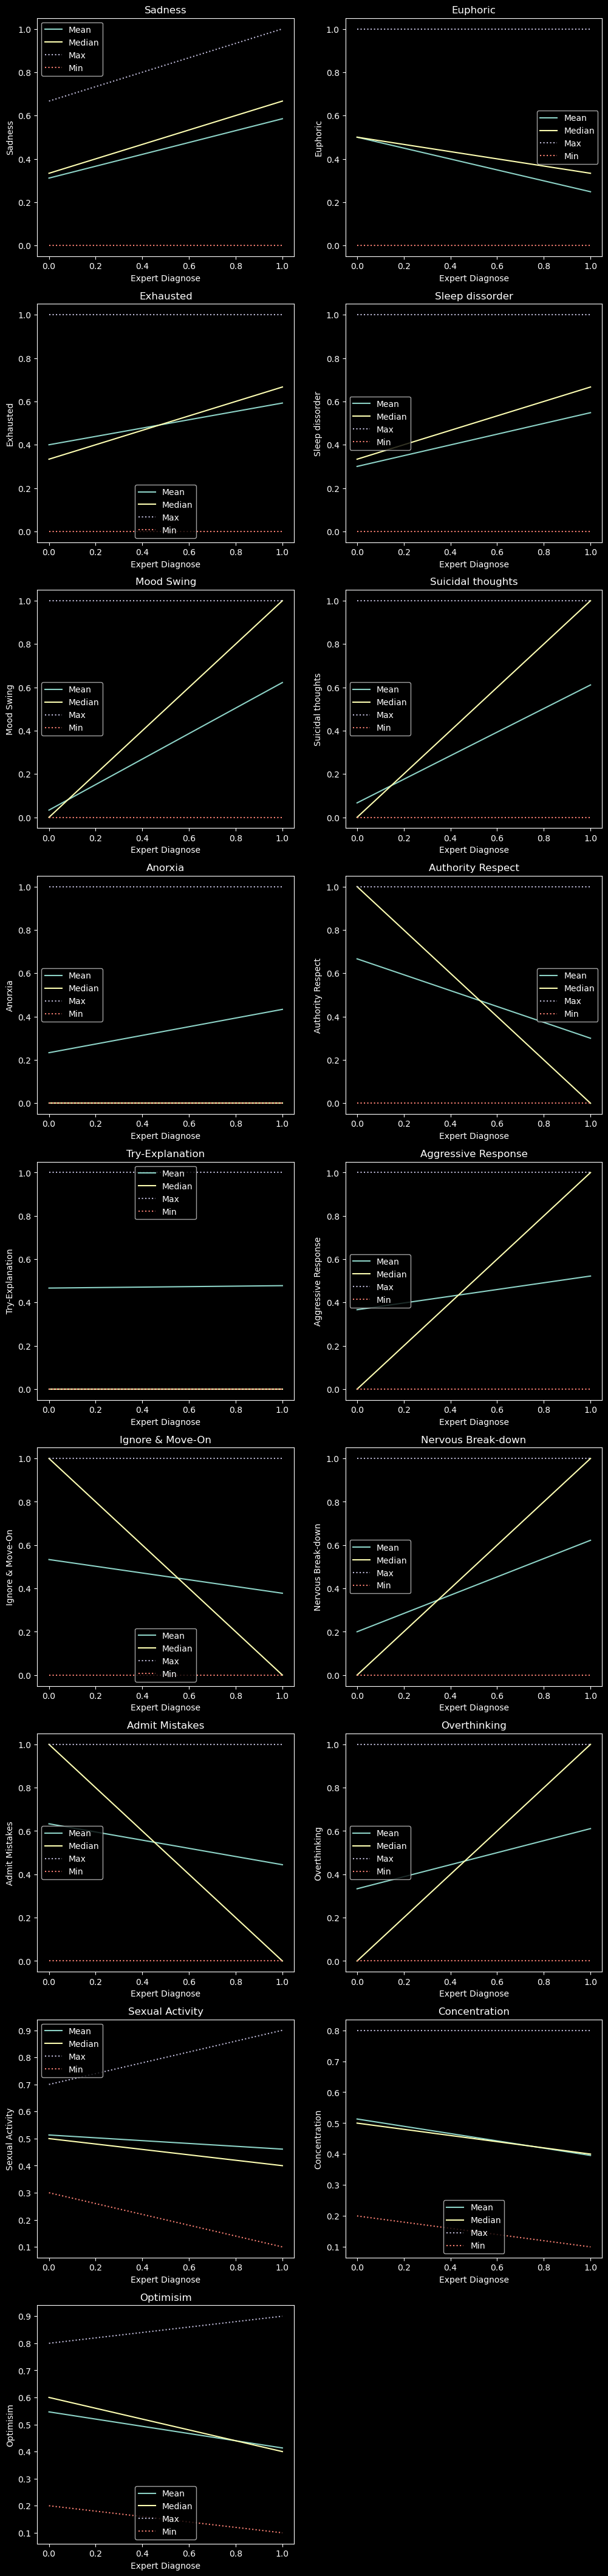

In [25]:
# 전체 데이터 그래프
drawPlot(data, 'Expert Diagnose')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [139]:
OptKNeighbours(
    data,
    data.columns.drop("Expert Diagnose"),
    "Expert Diagnose",
    0.3,
    2025
)

X_train(84, 17), X_test(36, 17), y_train(84,), y_test(36,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,이웃 수,정확도,정밀도,재현율
0,3,0.972222,0.968750,1.000000
0,5,0.972222,0.968750,1.000000
0,7,0.972222,0.968750,1.000000
0,27,0.944444,0.939394,1.000000
0,29,0.944444,0.939394,1.000000
0,31,0.944444,0.939394,1.000000
0,33,0.944444,0.939394,1.000000
0,35,0.944444,0.939394,1.000000
0,9,0.916667,0.937500,0.967742
0,11,0.916667,0.937500,0.967742


In [149]:
OptDecisionTree(
    data,
    data.columns.drop("Expert Diagnose"),
    "Expert Diagnose",
    0.3,
    2025
)

X_train(84, 17), X_test(36, 17), y_train(84,), y_test(36,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,3,2,6,0.972222,0.968750,1.0
0,4,7,8,0.944444,0.939394,1.0
0,1,1,3,0.861111,0.861111,1.0
0,1,1,6,0.861111,0.861111,1.0
0,1,1,7,0.861111,0.861111,1.0
0,1,1,8,0.861111,0.861111,1.0
0,1,2,2,0.861111,0.861111,1.0
0,1,2,4,0.861111,0.861111,1.0
0,1,2,5,0.861111,0.861111,1.0
0,1,3,4,0.861111,0.861111,1.0


In [150]:
OptRandomForest(
    data,
    data.columns.drop("Expert Diagnose"),
    "Expert Diagnose",
    0.3,
    2025
)

X_train(84, 17), X_test(36, 17), y_train(84,), y_test(36,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,6,2,4,0.944444,0.939394,1.0
0,2,2,4,0.916667,0.911765,1.0
0,2,2,6,0.916667,0.911765,1.0
0,2,2,7,0.916667,0.911765,1.0
0,3,1,4,0.916667,0.911765,1.0
0,3,1,5,0.916667,0.911765,1.0
0,3,1,6,0.916667,0.911765,1.0
0,3,1,7,0.916667,0.911765,1.0
0,4,1,6,0.916667,0.911765,1.0
0,4,1,8,0.916667,0.911765,1.0


# 데이터2 (X)
- 결과를 내기 위해 예측 결과를 이진화 했으나 최종적으로 정상, 비정상을 구분할 수 있는 데이터가 아니기 때문에 제외한다.

## 전처리

In [29]:
data = pd.read_csv("./data/me_cfs_vs_depression_dataset.csv")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,25,Female,8.2,9.2,8.8,3.6,10.0,6.9,29.0,3.2,0,Partially working,Medium,NaN,Yes,Depression
996,66,Male,9.7,1.3,2.4,2.8,9.0,7.0,34.0,NaN,1,Working,Very high,Rarely,No,ME/CFS
997,52,Male,8.7,4.2,8.7,3.4,7.0,7.0,40.0,9.2,1,Working,Very high,Daily,Yes,ME/CFS
998,69,Male,2.1,1.1,9.9,2.5,15.0,3.5,37.0,3.3,0,Partially working,Low,Never,No,Depression


### 데이터 정보

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           1000 non-null   int64  
 1   gender                        1000 non-null   object 
 2   sleep_quality_index           953 non-null    float64
 3   brain_fog_level               952 non-null    float64
 4   physical_pain_score           966 non-null    float64
 5   stress_level                  952 non-null    float64
 6   depression_phq9_score         978 non-null    float64
 7   fatigue_severity_scale_score  979 non-null    float64
 8   pem_duration_hours            976 non-null    float64
 9   hours_of_sleep_per_night      979 non-null    float64
 10  pem_present                   1000 non-null   int64  
 11  work_status                   953 non-null    object 
 12  social_activity_level         960 non-null    object 
 13  exer

### 결측치 처리

In [31]:
# 결측치 확인
data.isnull().sum()

age                              0
gender                           0
sleep_quality_index             47
brain_fog_level                 48
physical_pain_score             34
stress_level                    48
depression_phq9_score           22
fatigue_severity_scale_score    21
pem_duration_hours              24
hours_of_sleep_per_night        21
pem_present                      0
work_status                     47
social_activity_level           40
exercise_frequency              39
meditation_or_mindfulness       11
diagnosis                        0
dtype: int64

<Axes: >

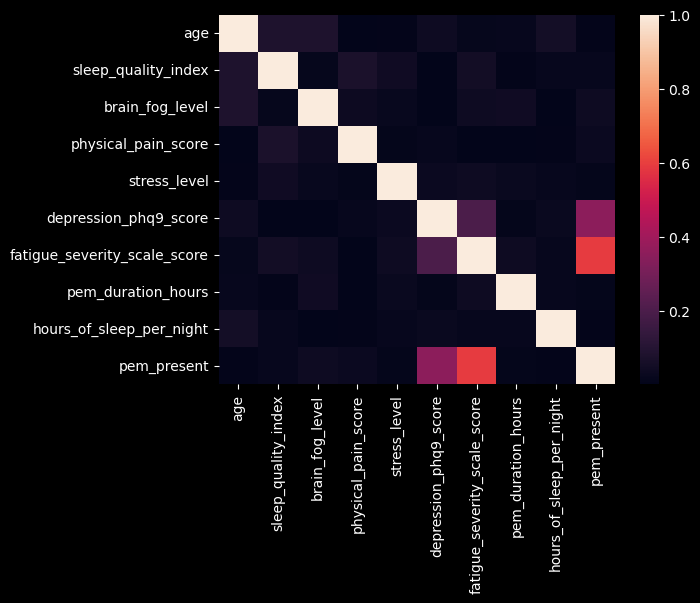

In [32]:
# 상관계수 확인
sns.heatmap(data.corr(numeric_only = True).abs())

In [33]:
# 결측치를 채우기 애매하므로 단순히 제거
data.dropna(inplace = True)
data.count()

age                             670
gender                          670
sleep_quality_index             670
brain_fog_level                 670
physical_pain_score             670
stress_level                    670
depression_phq9_score           670
fatigue_severity_scale_score    670
pem_duration_hours              670
hours_of_sleep_per_night        670
pem_present                     670
work_status                     670
social_activity_level           670
exercise_frequency              670
meditation_or_mindfulness       670
diagnosis                       670
dtype: int64

### 이상치 처리

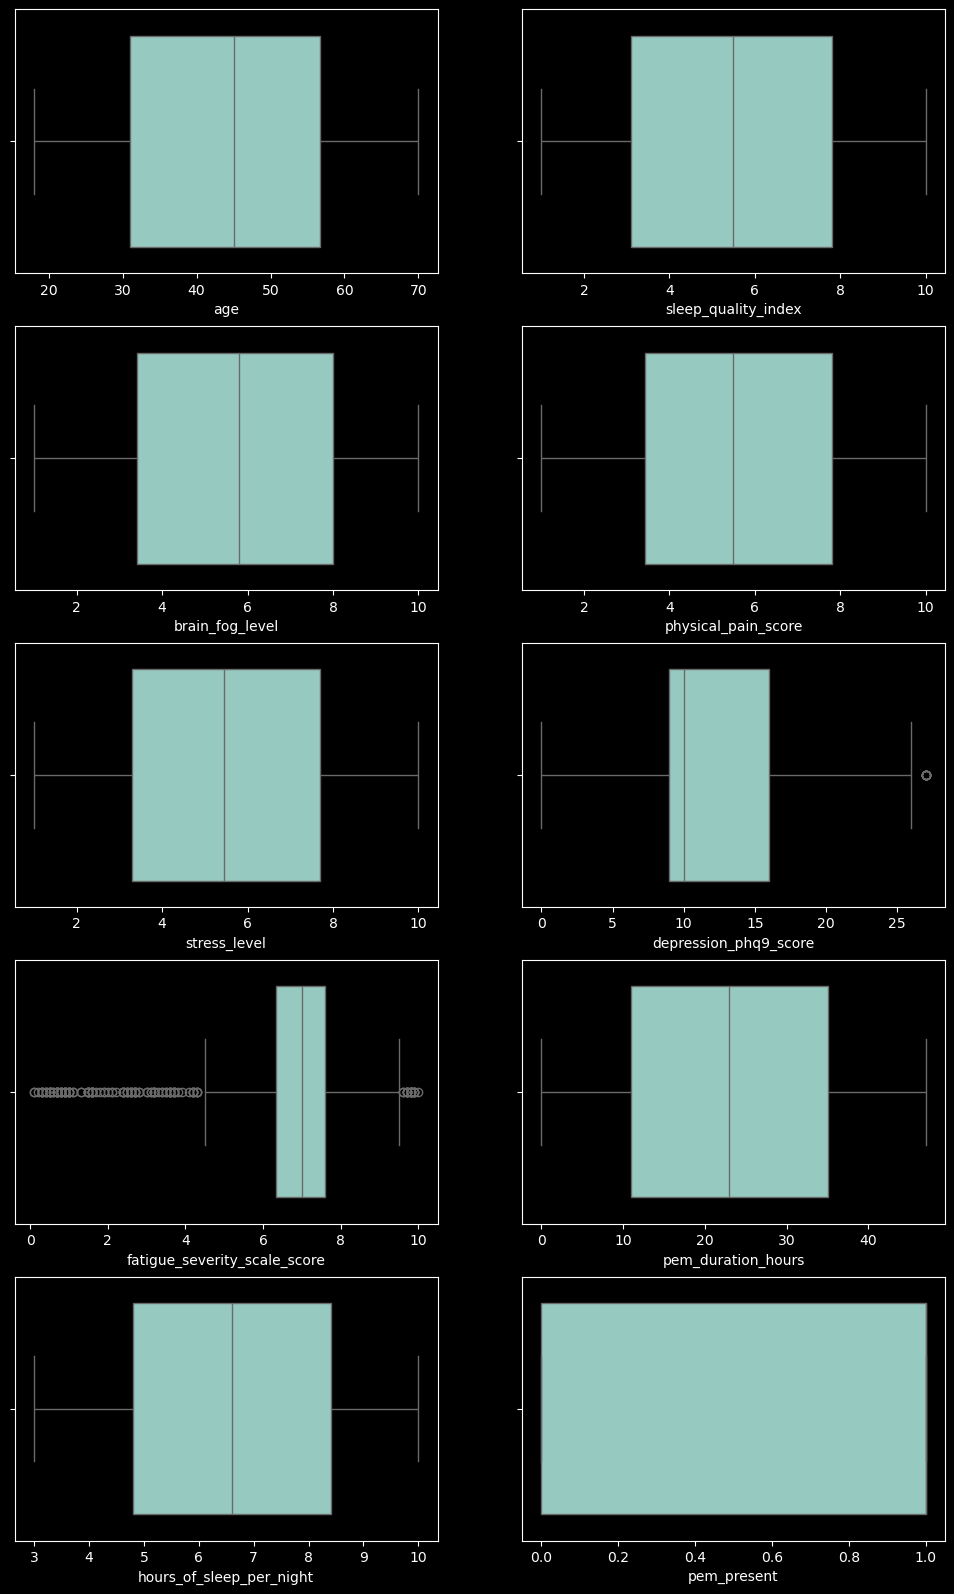

In [34]:
drawBoxPlot(data)

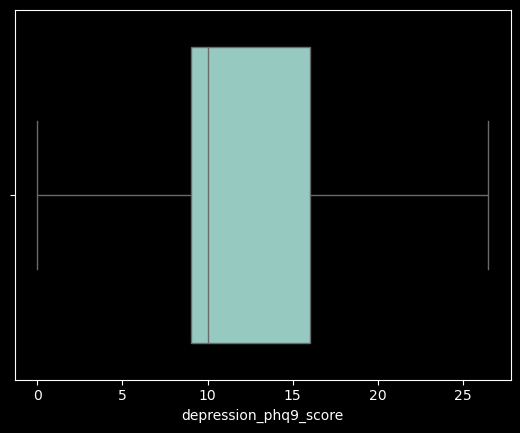

In [35]:
# depression_phq9_score, fatigue_severity_scale_score에서 이상치 확인.
# fatigue_severity_scale_score의 이상치는 다수가 밀하게 분포하므로 depression_phq9_score의 이상치만 수정.
fixValues(data, ['depression_phq9_score'])
sns.boxplot(x = data['depression_phq9_score'])
plt.show()

### 인코딩 & 스케일링

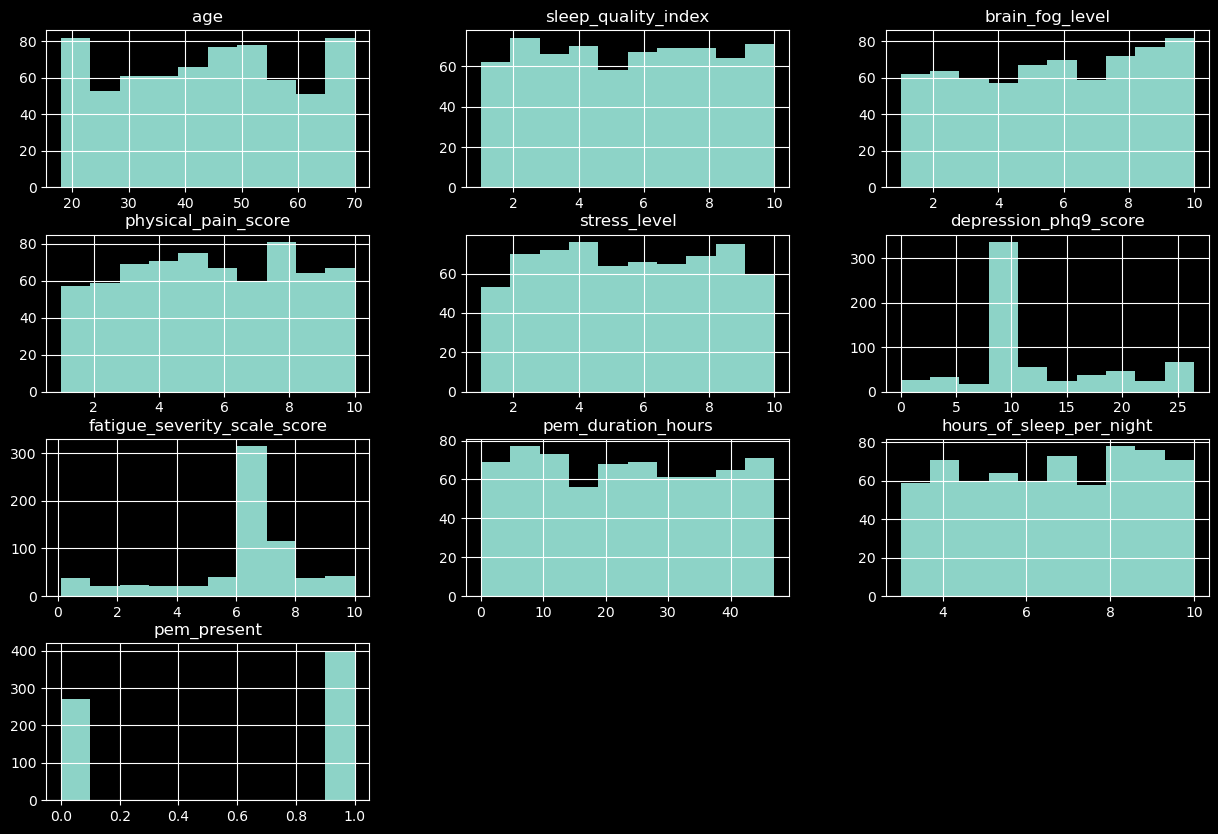

In [36]:
# 수치 특성 분포
numericList = numericFeature(data)

In [37]:
# 최대최소 스케일링
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,age,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present
0,0.730769,0.855556,0.322222,0.911111,0.788889,0.377358,0.646465,0.191489,0.671429,0.0
1,0.980769,0.033333,0.988889,0.355556,0.988889,0.754717,0.696970,0.872340,0.771429,1.0
3,0.269231,0.933333,0.122222,0.211111,0.311111,0.377358,0.676768,0.234043,0.642857,0.0
4,0.807692,0.733333,0.722222,0.600000,0.833333,0.641509,0.696970,0.978723,0.014286,1.0
5,0.134615,0.277778,0.322222,0.600000,0.611111,0.339623,0.747475,0.872340,0.157143,1.0
...,...,...,...,...,...,...,...,...,...,...
990,0.903846,0.033333,0.700000,0.366667,0.511111,0.339623,0.696970,0.404255,0.328571,1.0
993,0.673077,0.822222,0.822222,0.122222,0.844444,0.867925,0.858586,0.936170,0.157143,1.0
997,0.653846,0.855556,0.355556,0.855556,0.266667,0.264151,0.696970,0.851064,0.885714,1.0
998,0.980769,0.122222,0.011111,0.988889,0.166667,0.566038,0.343434,0.787234,0.042857,0.0


In [38]:
# 문자열 데이터 컬럼별 유니크 확인
getUnique(data)

gender
['Male' 'Female']

work_status
['Working' 'Not working' 'Partially working']

social_activity_level
['Low' 'High' 'Medium' 'Very low' 'Very high']

exercise_frequency
['Daily' 'Often' 'Never' 'Rarely' 'Sometimes']

meditation_or_mindfulness
['Yes' 'No']

diagnosis
['Depression' 'Both' 'ME/CFS']



In [39]:
# 0에서 1 사이 값으로 인코딩
orderedEncoding(data, ['gender'], ['Male', 'Female'])
orderedEncoding(data, ['work_status'], ['working', 'Partially working', 'Working'])
orderedEncoding(data, ['social_activity_level'], ['Very low', 'Low', 'Medium', 'High', 'Very high'])
orderedEncoding(data, ['exercise_frequency'], ['Never', 'Rarely', 'Sometimes', 'Often', 'Daily'])
orderedEncoding(data, ['meditation_or_mindfulness'], ['No', 'Yes'])
data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,0.730769,0.0,0.855556,0.322222,0.911111,0.788889,0.377358,0.646465,0.191489,0.671429,0.0,1.0,0.25,1.00,1.0,Depression
1,0.980769,0.0,0.033333,0.988889,0.355556,0.988889,0.754717,0.696970,0.872340,0.771429,1.0,1.0,0.25,0.75,1.0,Both
3,0.269231,1.0,0.933333,0.122222,0.211111,0.311111,0.377358,0.676768,0.234043,0.642857,0.0,0.0,0.75,0.00,1.0,Depression
4,0.807692,1.0,0.733333,0.722222,0.600000,0.833333,0.641509,0.696970,0.978723,0.014286,1.0,0.0,0.25,0.25,0.0,Both
5,0.134615,1.0,0.277778,0.322222,0.600000,0.611111,0.339623,0.747475,0.872340,0.157143,1.0,0.0,0.50,0.00,0.0,ME/CFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0.903846,0.0,0.033333,0.700000,0.366667,0.511111,0.339623,0.696970,0.404255,0.328571,1.0,0.0,1.00,0.50,1.0,ME/CFS
993,0.673077,0.0,0.822222,0.822222,0.122222,0.844444,0.867925,0.858586,0.936170,0.157143,1.0,0.0,0.50,1.00,1.0,Both
997,0.653846,0.0,0.855556,0.355556,0.855556,0.266667,0.264151,0.696970,0.851064,0.885714,1.0,1.0,1.00,1.00,1.0,ME/CFS
998,0.980769,0.0,0.122222,0.011111,0.988889,0.166667,0.566038,0.343434,0.787234,0.042857,0.0,0.0,0.25,0.00,0.0,Depression


In [40]:
# 정답 데이터 인코딩
answerEncoding(data, 'diagnosis', 'ME/CFS')
data['diagnosis']

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


0      1
1      1
3      1
4      1
5      0
      ..
990    0
993    1
997    0
998    1
999    1
Name: diagnosis, Length: 670, dtype: int64

### 데이터 저장

In [41]:
data.to_csv("./data/Preprocessed/DataSet2.csv")

## 가설

In [129]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet2.csv").drop("Unnamed: 0", axis = 1)

### 데이터 정보

In [42]:
# 상관계수
data.corr().abs()['diagnosis'].sort_values(ascending = False)

diagnosis                       1.000000
pem_present                     0.654254
depression_phq9_score           0.629243
fatigue_severity_scale_score    0.395295
work_status                     0.086150
sleep_quality_index             0.058144
physical_pain_score             0.048301
brain_fog_level                 0.039194
meditation_or_mindfulness       0.029624
hours_of_sleep_per_night        0.013370
pem_duration_hours              0.013246
social_activity_level           0.010998
stress_level                    0.008521
exercise_frequency              0.005508
gender                          0.004754
age                             0.002652
Name: diagnosis, dtype: float64

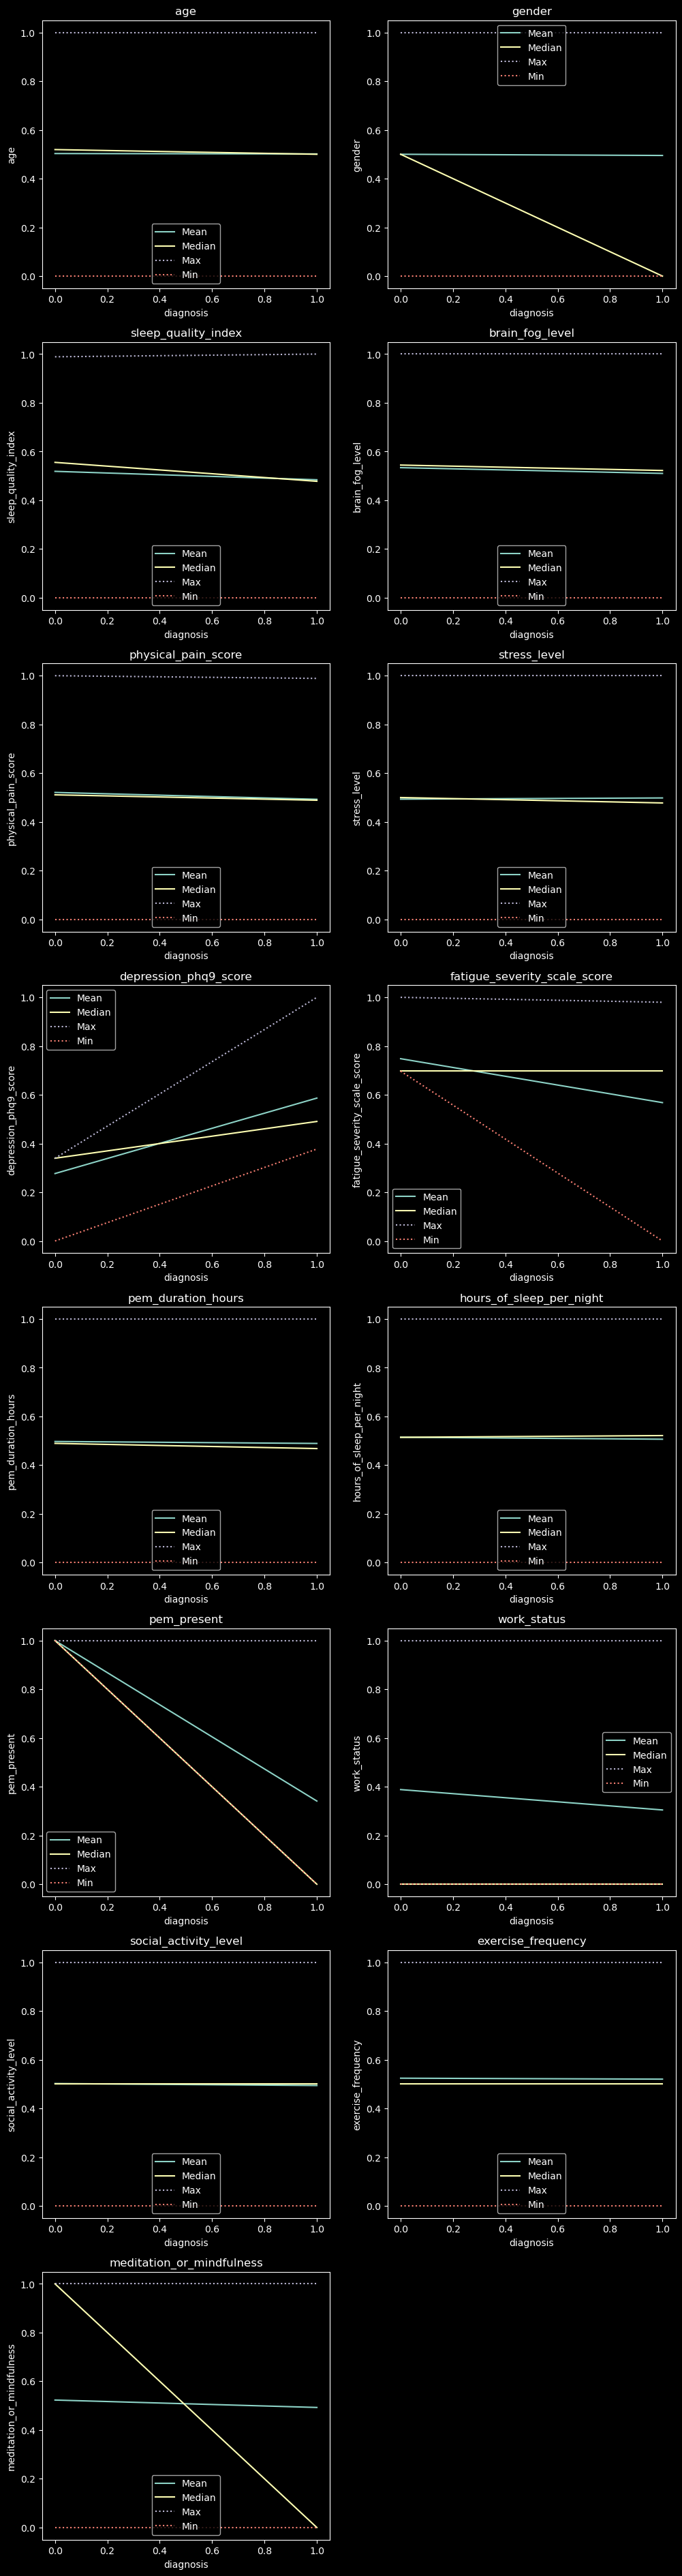

In [43]:
drawPlot(data, 'diagnosis')

# 데이터3 (X)
- 각 컬럼이 무엇을 의미하는지 알 수 없어서 보류한다.

## 전처리

In [47]:
data = pd.read_csv("./data/Indicators_of_Anxiety_or_Depression_Based_on_Reported_Frequency_of_Symptoms_During_Last_7_Days.csv")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.5,22.7,24.3,22.7 - 24.3,NaN
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,32.7,30.2,35.2,30.2 - 35.2,NaN
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,25.7,24.1,27.3,24.1 - 27.3,NaN
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,24.8,23.3,26.2,23.3 - 26.2,NaN
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.2,21.5,25.0,21.5 - 25.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11479,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Virginia,Virginia,3.6,50,"Oct 5 - Oct 17, 2022",10/05/2022,10/17/2022,33.5,29.6,37.5,29.6 - 37.5,33.4-35.7
11480,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Washington,Washington,3.6,50,"Oct 5 - Oct 17, 2022",10/05/2022,10/17/2022,36.9,32.6,41.4,32.6 - 41.4,35.8-38.5
11481,Symptoms of Anxiety Disorder or Depressive Dis...,By State,West Virginia,West Virginia,3.6,50,"Oct 5 - Oct 17, 2022",10/05/2022,10/17/2022,38.2,31.2,45.6,31.2 - 45.6,35.8-38.5
11482,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Wisconsin,Wisconsin,3.6,50,"Oct 5 - Oct 17, 2022",10/05/2022,10/17/2022,29.9,25.8,34.3,25.8 - 34.3,27.5-33.3


### 데이터 정보

In [48]:
# 데이터 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11484 entries, 0 to 11483
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Indicator               11484 non-null  object 
 1   Group                   11484 non-null  object 
 2   State                   11484 non-null  object 
 3   Subgroup                11484 non-null  object 
 4   Phase                   11484 non-null  object 
 5   Time Period             11484 non-null  int64  
 6   Time Period Label       11484 non-null  object 
 7   Time Period Start Date  11484 non-null  object 
 8   Time Period End Date    11484 non-null  object 
 9   Value                   10944 non-null  float64
 10  Low CI                  10944 non-null  float64
 11  High CI                 10944 non-null  float64
 12  Confidence Interval     10944 non-null  object 
 13  Quartile Range          7650 non-null   object 
dtypes: float64(3), int64(1), object(10)
me

In [49]:
# 유니크 확인
getUnique(data)

Indicator
['Symptoms of Depressive Disorder' 'Symptoms of Anxiety Disorder'
 'Symptoms of Anxiety Disorder or Depressive Disorder']

Group
['National Estimate' 'By Age' 'By Sex' 'By Race/Hispanic ethnicity'
 'By Education' 'By State' 'By Disability status' 'By Gender identity'
 'By Sexual orientation']

State
['United States' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']

Subgroup
['United States' '18 - 29 years' '30 - 39 years' '40 - 49 

# 데이터4 (O)

## 전처리

In [50]:
data = pd.read_csv("./data/student_depression_dataset.csv", index_col = "id")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,
2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0


### 데이터 정보

In [51]:
# 데이터 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 2 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  object 
 3   Profession                             27901 non-null  object 
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  object 
 10  Dietary Habits                         27901 non-null  object 
 11  Degree

### 불필요한 학습 데이터 제거

In [52]:
data.drop(['City', 'Profession'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 2 to 140699
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   Academic Pressure                      27901 non-null  float64
 3   Work Pressure                          27901 non-null  float64
 4   CGPA                                   27901 non-null  float64
 5   Study Satisfaction                     27901 non-null  float64
 6   Job Satisfaction                       27901 non-null  float64
 7   Sleep Duration                         27901 non-null  object 
 8   Dietary Habits                         27901 non-null  object 
 9   Degree                                 27901 non-null  object 
 10  Have you ever had suicidal thoughts ?  27901 non-null  object 
 11  Work/S

### 결측치 확인

In [53]:
# 결측치 확인
data.isnull().sum()

Gender                                   0
Age                                      0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

### 이상치 확인

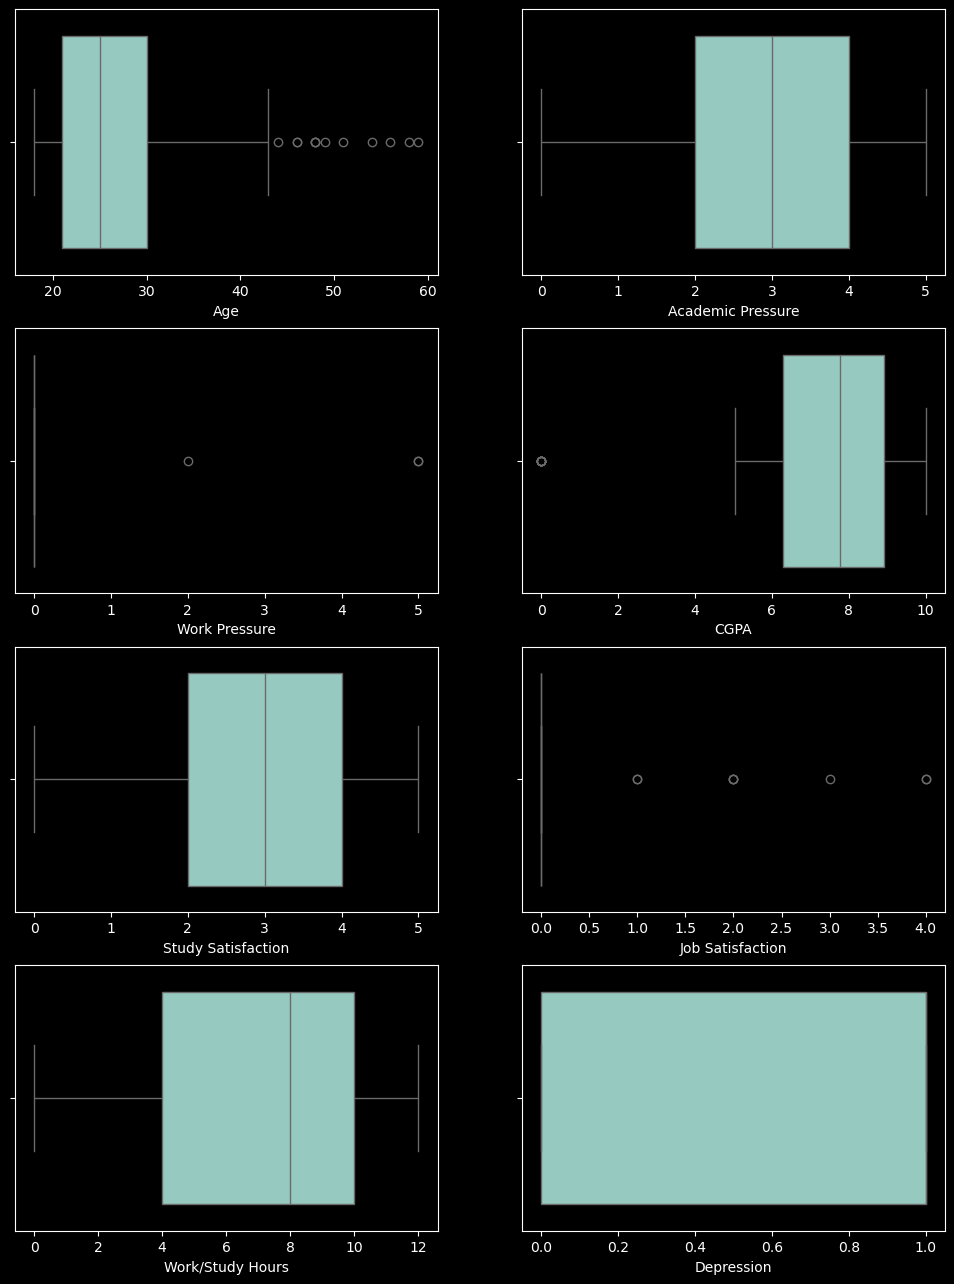

In [54]:
# 이상치 확인
# 여러 요소에서 이상치가 확인되나 전부 잘못된 값은 아니기 때문에 처리하지 않는다.
drawBoxPlot(data)

### 인코딩 & 스케일링

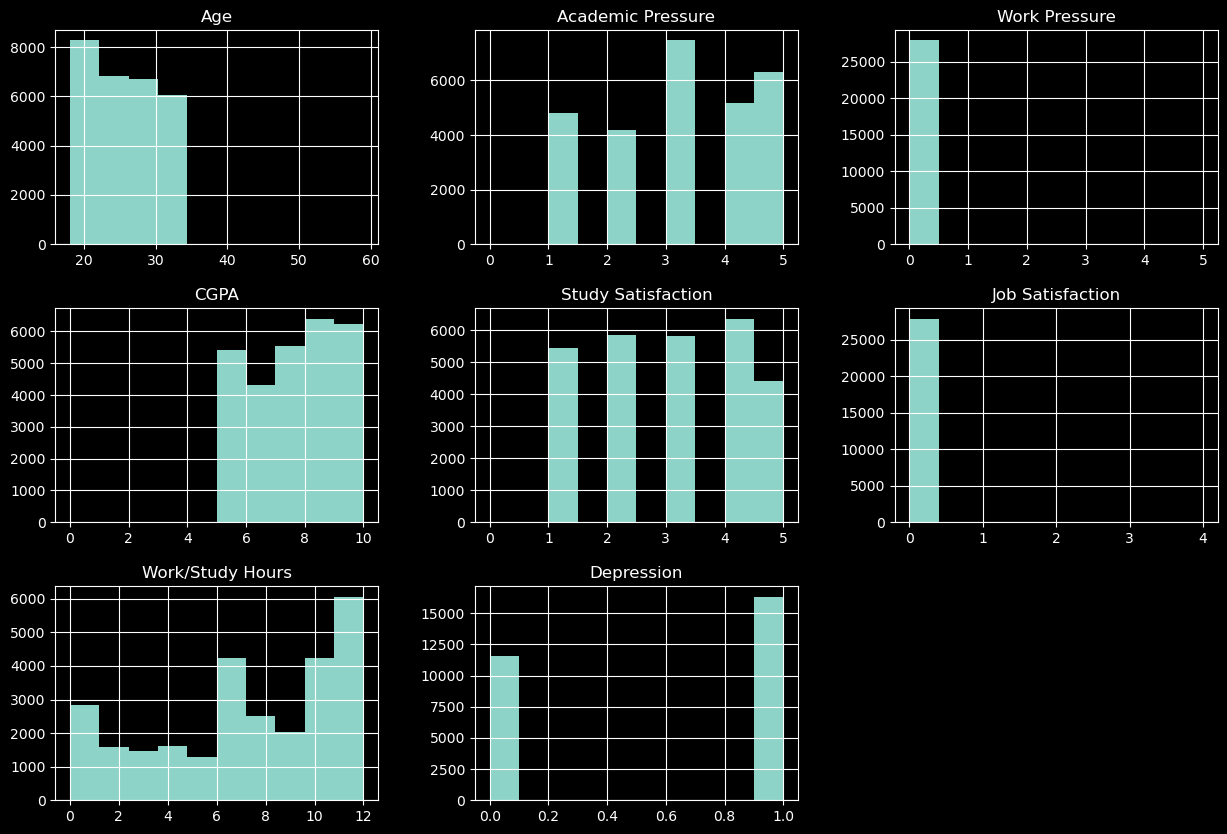

In [55]:
# 수치 데이터 분포
numericList = numericFeature(data)

In [56]:
# 최대최소 스케일링
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
id,,,,,,,,
2,0.365854,1.0,0.0,0.897,0.4,0.0,0.250000,1.0
8,0.146341,0.4,0.0,0.590,1.0,0.0,0.250000,0.0
26,0.317073,0.6,0.0,0.703,1.0,0.0,0.750000,0.0
30,0.243902,0.6,0.0,0.559,0.4,0.0,0.333333,1.0
32,0.170732,0.8,0.0,0.813,0.6,0.0,0.083333,0.0
...,...,...,...,...,...,...,...,...
140685,0.219512,1.0,0.0,0.575,1.0,0.0,0.583333,0.0
140686,0.219512,0.4,0.0,0.940,0.6,0.0,0.000000,0.0
140689,0.317073,0.6,0.0,0.661,0.8,0.0,1.000000,0.0


In [57]:
# 문자열 데이터 유니크 확인
getUnique(data)

Gender
['Male' 'Female']

Sleep Duration
["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']

Dietary Habits
['Healthy' 'Moderate' 'Unhealthy' 'Others']

Degree
['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' "'Class 12'" 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']

Have you ever had suicidal thoughts ?
['Yes' 'No']

Financial Stress
['1.0' '2.0' '5.0' '3.0' '4.0' '?']

Family History of Mental Illness
['No' 'Yes']



In [58]:
# Financial Stress에서 '?' 값이 발견됨
# 값이 없는 것은 중립적으로 '3.0'으로 값을 채운다.
data.loc[data['Financial Stress'] == '?', 'Financial Stress'] = '3.0'
data['Financial Stress'].unique()

array(['1.0', '2.0', '5.0', '3.0', '4.0'], dtype=object)

In [59]:
orderedEncoding(
    data,
    {
        'Have you ever had suicidal thoughts ?' : ['No', 'Yes'],
        'Family History of Mental Illness' : ['No', 'Yes'],
        'Gender' : ['Male', 'Female'],
        'Sleep Duration' : ['Others', "'Less than 5 hours'", "'5-6 hours'", "'7-8 hours'", "'More than 8 hours'"],
        'Dietary Habits' : ['Others', 'Unhealthy', 'Moderate', 'Healthy'],
        'Financial Stress' : ['1.0', '2.0', '3.0', '4.0', '5.0'],
        'Degree' : ['Others', 'Class 12', 'BSc', 'B.Com', 'BA', 'BBA', 'BHM', 'B.Ed', 'BCA', 'B.Pharm', 'B.Tech', 'BE', 'LLB', 'B.Arch', 'MA', 'MSc', 'M.Com', 'M.Ed', 'MHM', 'MCA', 'M.Pharm', 'MBA', 'M.Tech', 'ME', 'LLM', 'MBBS', 'MD', 'PhD']
    }
)
data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,
2,0.0,0.365854,1.0,0.0,0.897,0.4,0.0,0.50,1.000000,0.333333,1.0,0.250000,0.00,0.0,1.0
8,1.0,0.146341,0.4,0.0,0.590,1.0,0.0,0.50,0.666667,0.074074,0.0,0.250000,0.25,1.0,0.0
26,0.0,0.317073,0.6,0.0,0.703,1.0,0.0,0.25,1.000000,0.148148,0.0,0.750000,0.00,1.0,0.0
30,1.0,0.243902,0.6,0.0,0.559,0.4,0.0,0.75,0.666667,0.296296,1.0,0.333333,1.00,1.0,1.0
32,1.0,0.170732,0.8,0.0,0.813,0.6,0.0,0.50,0.666667,0.814815,1.0,0.083333,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,1.0,0.219512,1.0,0.0,0.575,1.0,0.0,0.50,0.333333,0.037037,1.0,0.583333,0.00,1.0,0.0
140686,0.0,0.219512,0.4,0.0,0.940,0.6,0.0,0.25,1.000000,0.555556,0.0,0.000000,0.50,1.0,0.0
140689,0.0,0.317073,0.6,0.0,0.661,0.8,0.0,0.50,0.333333,0.962963,0.0,1.000000,0.25,0.0,0.0


### 데이터 저장

In [60]:
data.to_csv("./data/Preprocessed/DataSet4.csv")

## 가설

In [151]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet4.csv", index_col = "id")

### 데이터 정보

In [61]:
# 상관계수
data.corr()['Depression'].abs().sort_values(ascending = False)

Depression                               1.000000
Have you ever had suicidal thoughts ?    0.546277
Academic Pressure                        0.474835
Financial Stress                         0.363574
Age                                      0.226422
Work/Study Hours                         0.208563
Dietary Habits                           0.206563
Study Satisfaction                       0.167971
Degree                                   0.091646
Sleep Duration                           0.086690
Family History of Mental Illness         0.053430
CGPA                                     0.022210
Job Satisfaction                         0.003482
Work Pressure                            0.003351
Gender                                   0.001794
Name: Depression, dtype: float64

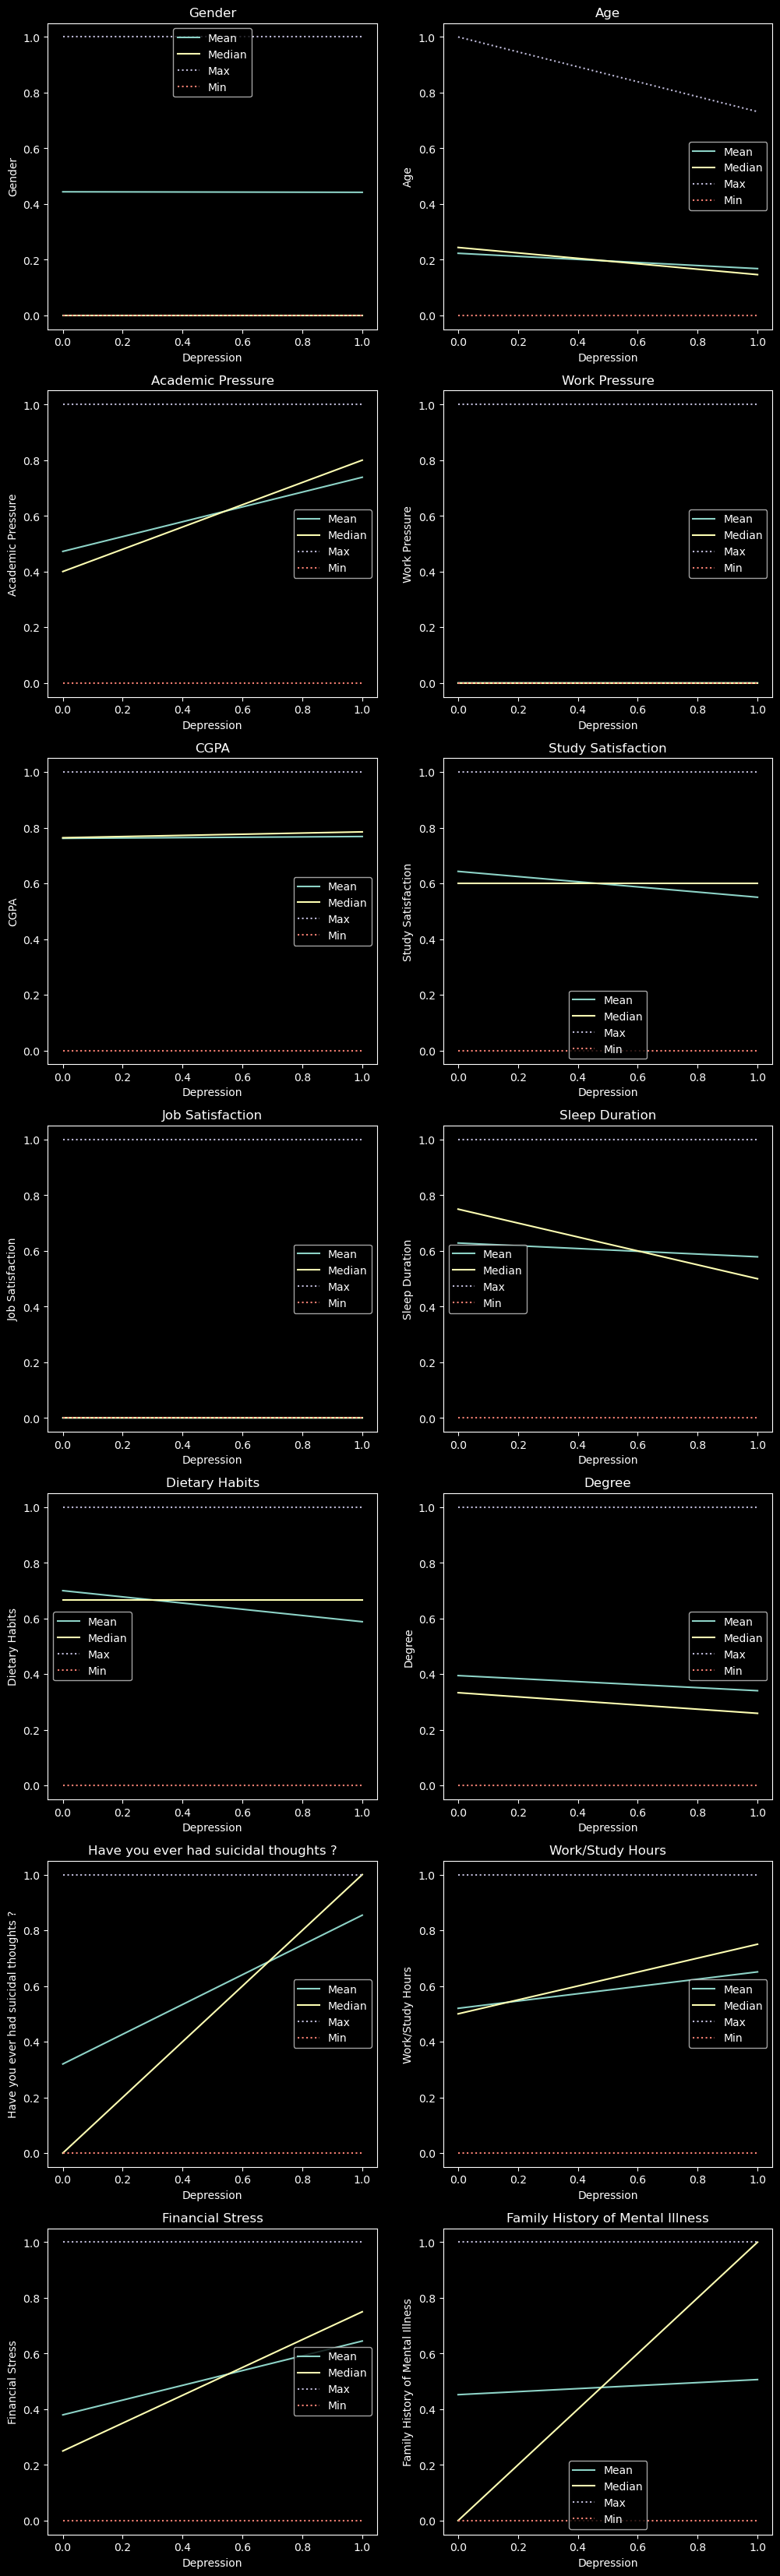

In [62]:
# 모든 데이터가 수치 데이터임에도 타입이 object인 컬럼이 존재
for i in data.columns:
    if data[i].dtype == object:
        data[i] = data[i].astype(float)
        
# 전체 데이터 그래프
drawPlot(data, 'Depression')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [154]:
OptKNeighbours(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


,이웃 수,정확도,정밀도,재현율
0,45,0.831084,0.834107,0.885832
0,55,0.829411,0.832111,0.885421
0,41,0.831561,0.835271,0.885010
0,51,0.830606,0.833978,0.885010
0,43,0.830964,0.834592,0.884805
0,53,0.829889,0.833140,0.884805
0,21,0.833234,0.837938,0.884394
0,37,0.831800,0.835986,0.884394
0,31,0.832039,0.836441,0.884189
0,23,0.831681,0.835954,0.884189


In [155]:
OptDecisionTree(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,1,1,3,0.581770,0.581770,1.000000
0,1,1,4,0.581770,0.581770,1.000000
0,1,1,6,0.581770,0.581770,1.000000
0,1,2,7,0.581770,0.581770,1.000000
0,1,2,8,0.581770,0.581770,1.000000
0,1,3,3,0.581770,0.581770,1.000000
0,1,3,4,0.581770,0.581770,1.000000
0,1,3,7,0.581770,0.581770,1.000000
0,1,3,8,0.581770,0.581770,1.000000
0,1,4,3,0.581770,0.581770,1.000000


In [156]:
OptRandomForest(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,1,1,2,0.594314,0.589160,1.000000
0,1,1,3,0.587743,0.585266,1.000000
0,2,1,2,0.586429,0.584494,1.000000
0,1,1,4,0.584040,0.583094,1.000000
0,5,1,2,0.601362,0.593419,0.999795
0,1,1,5,0.607693,0.597301,0.999589
0,1,1,6,0.604229,0.595183,0.999589
0,1,1,7,0.602556,0.594166,0.999589
0,7,1,2,0.602318,0.594021,0.999589
0,1,1,8,0.618803,0.604221,0.999384


# 데이터5 (O)

## 전처리

In [66]:
data = pd.read_csv("./data/b_depressed.csv", index_col = "Survey_id")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
Survey_id,,,,,,,,,,,,,,,,,,,,,
926,91,1,28,1,4,10,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
747,57,1,23,1,3,8,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
1190,115,1,22,1,3,9,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1065,97,1,27,1,2,10,4,52667108,19698904,49647648,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
806,42,0,59,0,4,10,6,82606287,17352654,23399979,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,22,1,25,1,1,7,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
547,69,1,28,1,4,10,6,15711078,24023054,15506558,...,0,1,0,0,23022095,1021536,0,1823477,47384361.0,0
893,184,1,66,0,0,1,1,42440731,22861940,22562605,...,0,1,0,0,12545373,10454478,0,46444572,10454478.0,1


### 데이터 정보

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 926 to 231
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ville_id               1429 non-null   int64  
 1   sex                    1429 non-null   int64  
 2   Age                    1429 non-null   int64  
 3   Married                1429 non-null   int64  
 4   Number_children        1429 non-null   int64  
 5   education_level        1429 non-null   int64  
 6   total_members          1429 non-null   int64  
 7   gained_asset           1429 non-null   int64  
 8   durable_asset          1429 non-null   int64  
 9   save_asset             1429 non-null   int64  
 10  living_expenses        1429 non-null   int64  
 11  other_expenses         1429 non-null   int64  
 12  incoming_salary        1429 non-null   int64  
 13  incoming_own_farm      1429 non-null   int64  
 14  incoming_business      1429 non-null   int64  
 15  incoming

### 불필요한 학습 데이터 제거

In [68]:
# 지역 코드는 제외한다.
data.drop('Ville_id', axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 926 to 231
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    1429 non-null   int64  
 1   Age                    1429 non-null   int64  
 2   Married                1429 non-null   int64  
 3   Number_children        1429 non-null   int64  
 4   education_level        1429 non-null   int64  
 5   total_members          1429 non-null   int64  
 6   gained_asset           1429 non-null   int64  
 7   durable_asset          1429 non-null   int64  
 8   save_asset             1429 non-null   int64  
 9   living_expenses        1429 non-null   int64  
 10  other_expenses         1429 non-null   int64  
 11  incoming_salary        1429 non-null   int64  
 12  incoming_own_farm      1429 non-null   int64  
 13  incoming_business      1429 non-null   int64  
 14  incoming_no_business   1429 non-null   int64  
 15  incoming

### 결측치 처리

In [69]:
# 결측치 확인
data.isnull().sum()

sex                       0
Age                       0
Married                   0
Number_children           0
education_level           0
total_members             0
gained_asset              0
durable_asset             0
save_asset                0
living_expenses           0
other_expenses            0
incoming_salary           0
incoming_own_farm         0
incoming_business         0
incoming_no_business      0
incoming_agricultural     0
farm_expenses             0
labor_primary             0
lasting_investment        0
no_lasting_investmen     20
depressed                 0
dtype: int64

In [70]:
# 결측치가 존재하는 인덱스
data[data['no_lasting_investmen'].isnull()]

,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,living_expenses,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
Survey_id,,,,,,,,,,,,,,,,,,,,,
467,1,19,1,1,7,3,22375139,20819981,23399979,66730708,...,1,0,0,0,30028818,31363432,1,24659033,NaN,0
685,1,25,1,1,7,3,28912201,25224208,23399979,93422991,...,1,0,0,0,30028818,31363432,1,31149896,NaN,0
17,0,75,0,0,4,1,28912201,28827665,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28827665,NaN,0
877,1,24,1,2,14,4,28912201,10249837,23399979,13346142,...,1,0,0,0,30028818,31363432,1,12652142,NaN,0
571,1,70,1,3,6,7,36763528,13132603,23399979,17349985,...,0,1,0,0,30028818,31363432,0,53099207,NaN,1
556,1,21,1,5,10,7,28912201,34433044,23399979,25624592,...,1,0,0,0,30028818,31363432,1,3683535,NaN,0
491,1,86,0,0,1,1,82606287,11531066,23399979,36034581,...,0,0,0,0,30028818,31363432,0,25397076,NaN,0
804,1,72,0,0,5,1,28912201,80076847,23399979,26692283,...,0,0,0,0,30028818,31363432,0,80076847,NaN,0
142,0,21,0,1,10,3,28912201,49087109,23399979,33365355,...,0,0,0,0,30028818,31363432,0,58696332,NaN,0


In [71]:
# no_lasting_investmen에 대한 상관계수
data.corr()['no_lasting_investmen'].abs().sort_values(ascending = False)

no_lasting_investmen     1.000000
farm_expenses            0.125146
incoming_own_farm        0.106510
incoming_salary          0.076819
incoming_agricultural    0.066920
labor_primary            0.057380
depressed                0.051973
Married                  0.050146
sex                      0.048166
total_members            0.048028
living_expenses          0.047035
lasting_investment       0.043120
gained_asset             0.030779
save_asset               0.028610
incoming_business        0.024069
Age                      0.023430
durable_asset            0.022460
other_expenses           0.018902
Number_children          0.014344
education_level          0.013849
incoming_no_business     0.004291
Name: no_lasting_investmen, dtype: float64

In [72]:
# 결측치를 채우기 애매하므로 단순히 제거
data.dropna(inplace = True)
data.isnull().sum()

sex                      0
Age                      0
Married                  0
Number_children          0
education_level          0
total_members            0
gained_asset             0
durable_asset            0
save_asset               0
living_expenses          0
other_expenses           0
incoming_salary          0
incoming_own_farm        0
incoming_business        0
incoming_no_business     0
incoming_agricultural    0
farm_expenses            0
labor_primary            0
lasting_investment       0
no_lasting_investmen     0
depressed                0
dtype: int64

### 이상치 확인

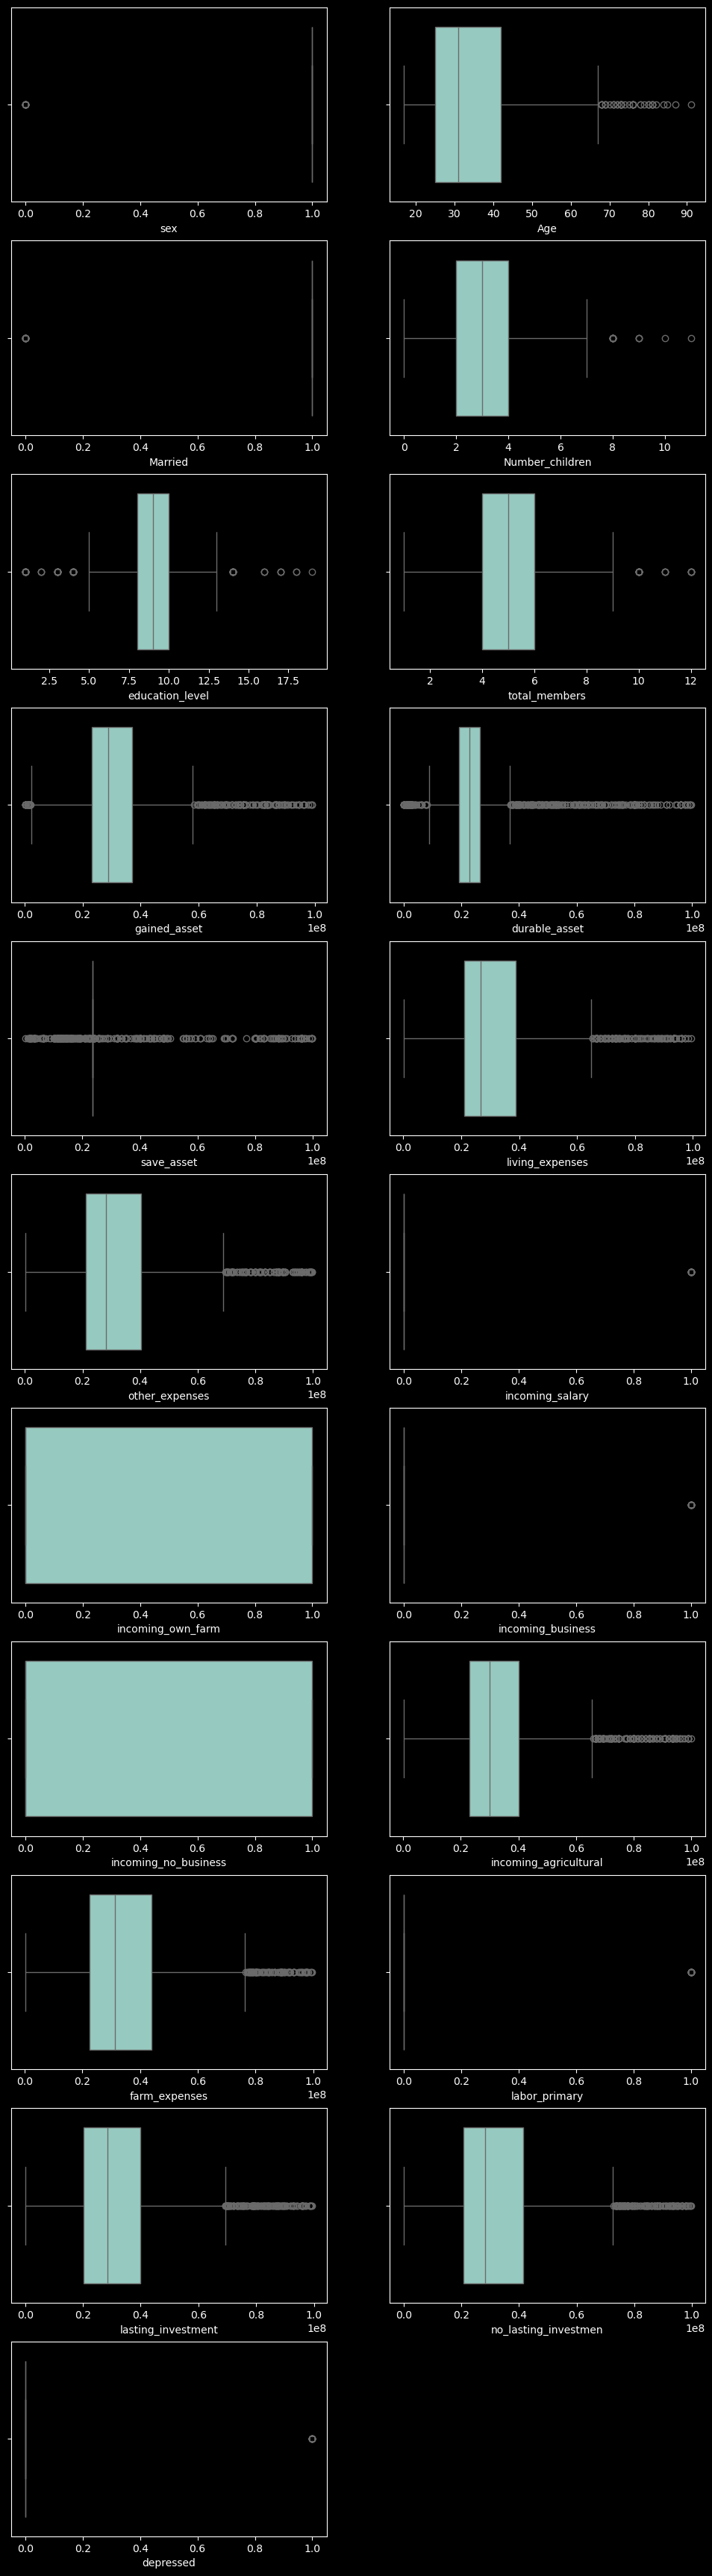

In [73]:
# 이상치 확인
drawBoxPlot(data)
# 여러 요소에서 이상치가 확인되나, 이상치더라도 분포가 많거나 잘못된 값이 아니기 때문에 처리하지 않는다.

### 스케일링

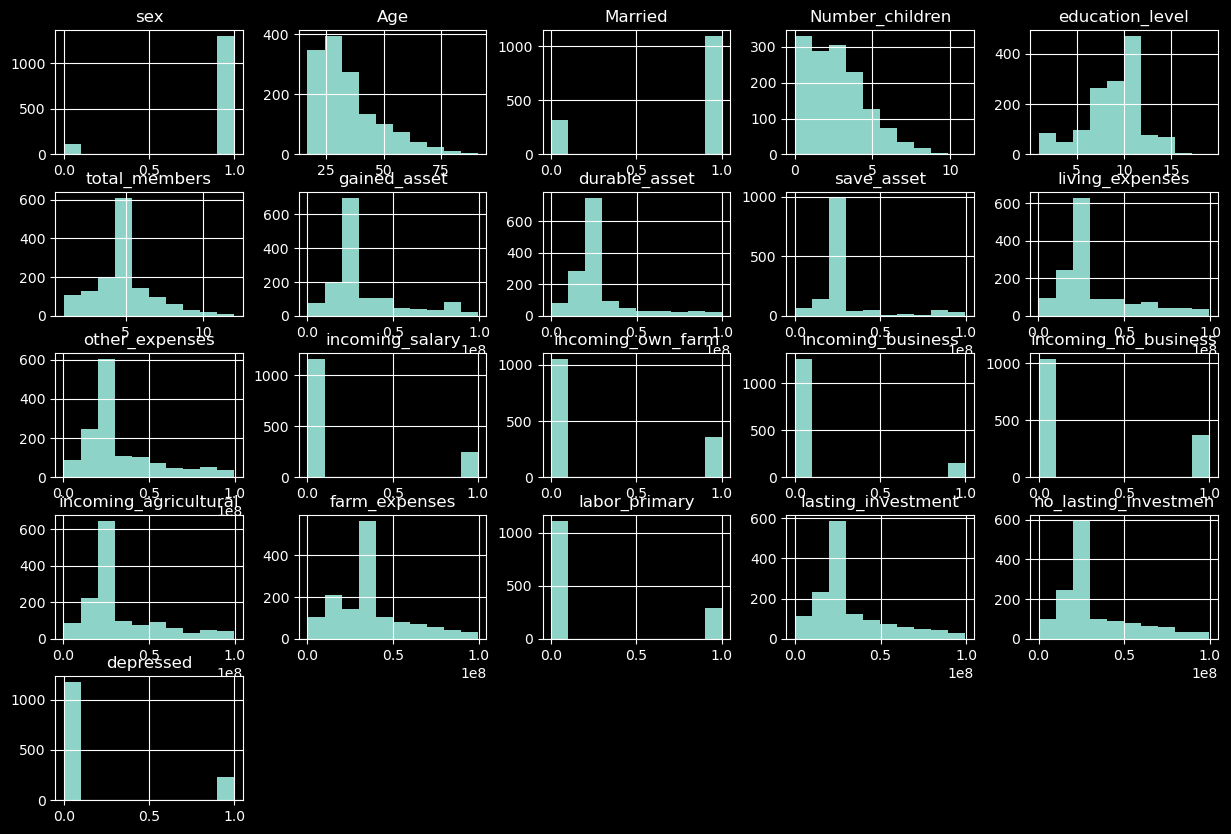

In [74]:
# 수치 데이터 분포
numericList = numericFeature(data)

In [75]:
# 일부 정규분포를 보이는 것 처럼 생긴 것이 있으나 대부분 애매한 형태기 때문에 최대최소 스케일링으로 통일한다.
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,living_expenses,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
Survey_id,,,,,,,,,,,,,,,,,,,,,
926,1.0,0.148649,1.0,0.363636,0.500000,0.363636,0.289336,0.228242,0.232843,0.266876,...,0.0,0.0,0.0,0.0,0.298638,0.312860,0.0,0.285164,0.283009,0.0
747,1.0,0.081081,1.0,0.272727,0.388889,0.363636,0.289336,0.228242,0.232843,0.266876,...,0.0,0.0,0.0,0.0,0.298638,0.312860,0.0,0.285164,0.283009,1.0
1190,1.0,0.067568,1.0,0.272727,0.444444,0.363636,0.289336,0.228242,0.232843,0.266876,...,0.0,0.0,0.0,0.0,0.298638,0.312860,0.0,0.285164,0.283009,0.0
1065,1.0,0.135135,1.0,0.181818,0.500000,0.272727,0.529764,0.196438,0.495968,0.001361,...,0.0,1.0,0.0,1.0,0.220813,0.185952,0.0,0.077555,0.694233,0.0
806,0.0,0.567568,0.0,0.363636,0.500000,0.454545,0.832785,0.172846,0.232843,0.814024,...,1.0,0.0,0.0,0.0,0.533454,0.205872,1.0,0.201528,0.434998,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1.0,0.108108,1.0,0.090909,0.333333,0.363636,0.289336,0.228242,0.232843,0.266876,...,0.0,0.0,0.0,0.0,0.298638,0.312860,0.0,0.285164,0.283009,0.0
547,1.0,0.148649,1.0,0.363636,0.500000,0.454545,0.155725,0.239917,0.153714,0.103136,...,0.0,1.0,0.0,0.0,0.228193,0.007547,0.0,0.017602,0.474837,0.0
893,1.0,0.662162,0.0,0.000000,0.000000,0.000000,0.426261,0.228242,0.224449,0.124025,...,0.0,1.0,0.0,0.0,0.122861,0.102465,0.0,0.466631,0.103775,1.0


### 데이터 저장

In [76]:
data.to_csv("./data/Preprocessed/DataSet5.csv")

## 가설

In [131]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet5.csv", index_col = "Survey_id")

### 데이터 정보

In [77]:
# 상관계수
data.corr()['depressed'].abs().sort_values(ascending = False)

depressed                1.000000
Age                      0.100126
education_level          0.097361
Married                  0.063588
no_lasting_investmen     0.051973
durable_asset            0.038323
total_members            0.033125
incoming_business        0.028586
incoming_no_business     0.026104
living_expenses          0.024149
incoming_agricultural    0.019415
save_asset               0.011379
other_expenses           0.011107
labor_primary            0.010302
incoming_own_farm        0.010019
sex                      0.005700
gained_asset             0.005111
farm_expenses            0.005059
lasting_investment       0.004459
Number_children          0.003406
incoming_salary          0.001813
Name: depressed, dtype: float64

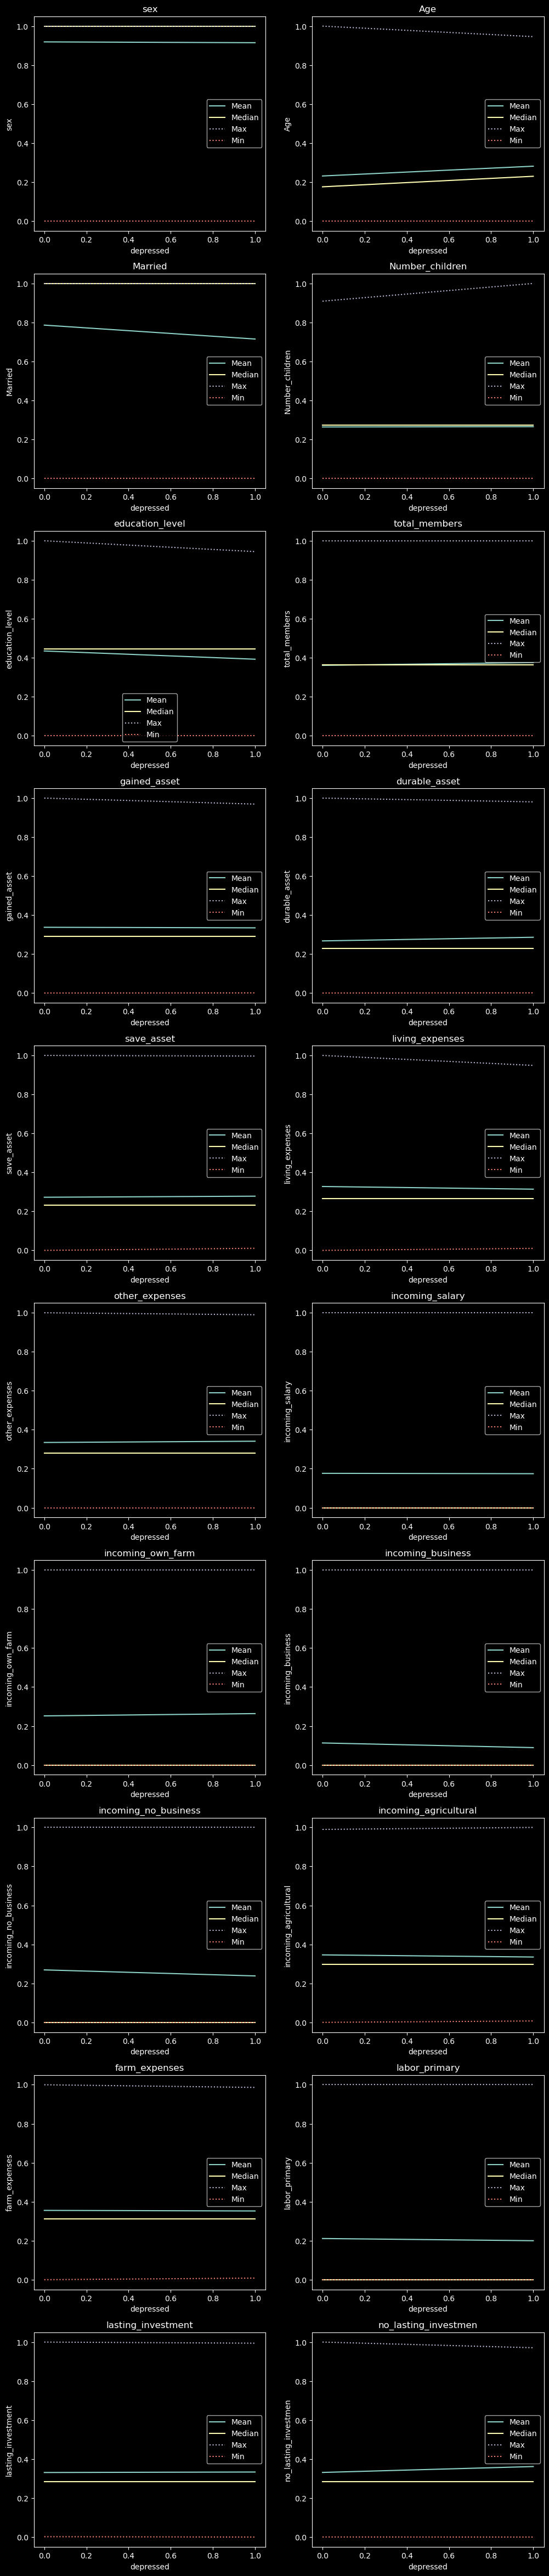

In [78]:
drawPlot(data, 'depressed')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [157]:
OptKNeighbours(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


,이웃 수,정확도,정밀도,재현율
0,45,0.831084,0.834107,0.885832
0,55,0.829411,0.832111,0.885421
0,41,0.831561,0.835271,0.885010
0,51,0.830606,0.833978,0.885010
0,43,0.830964,0.834592,0.884805
0,53,0.829889,0.833140,0.884805
0,21,0.833234,0.837938,0.884394
0,37,0.831800,0.835986,0.884394
0,31,0.832039,0.836441,0.884189
0,23,0.831681,0.835954,0.884189


In [158]:
OptDecisionTree(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,1,1,2,0.581770,0.581770,1.000000
0,1,1,5,0.581770,0.581770,1.000000
0,1,1,6,0.581770,0.581770,1.000000
0,1,1,8,0.581770,0.581770,1.000000
0,1,2,7,0.581770,0.581770,1.000000
0,1,2,8,0.581770,0.581770,1.000000
0,1,3,2,0.581770,0.581770,1.000000
0,1,3,5,0.581770,0.581770,1.000000
0,1,3,7,0.581770,0.581770,1.000000
0,1,4,4,0.581770,0.581770,1.000000


In [159]:
OptRandomForest(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(19530, 14), X_test(8371, 14), y_train(19530,), y_test(8371,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,1,1,4,0.595508,0.589874,1.000000
0,3,1,2,0.594553,0.589303,1.000000
0,7,1,2,0.592044,0.587809,1.000000
0,1,1,8,0.588460,0.585689,1.000000
0,4,1,2,0.588460,0.585689,1.000000
0,2,1,2,0.585713,0.584073,1.000000
0,1,1,6,0.583682,0.582885,1.000000
0,6,1,2,0.582487,0.582188,1.000000
0,8,1,2,0.612472,0.600247,0.999589
0,5,1,2,0.605782,0.596130,0.999589


# 데이터6 (O)

## 전처리

In [123]:
data = pd.read_csv("./data/depression_data.csv", index_col = "Name")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
Name,,,,,,,,,,,,,,,
Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes


### 데이터 정보

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

### 결측치 확인

In [82]:
# 결측치 확인
data.isnull().sum()

Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

### 이상치 확인

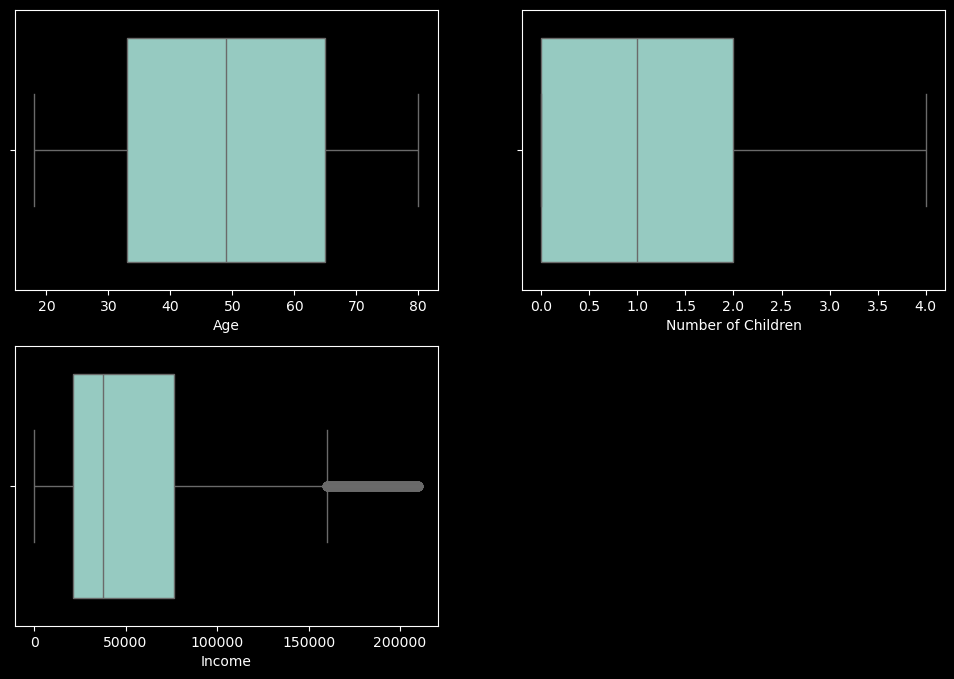

In [83]:
# 이상치 확인
drawBoxPlot(data)
# Income에서 이상치가 확인되나 분포가 많기 때문에 처리하지 않는다.

### 인코딩 & 스케일링

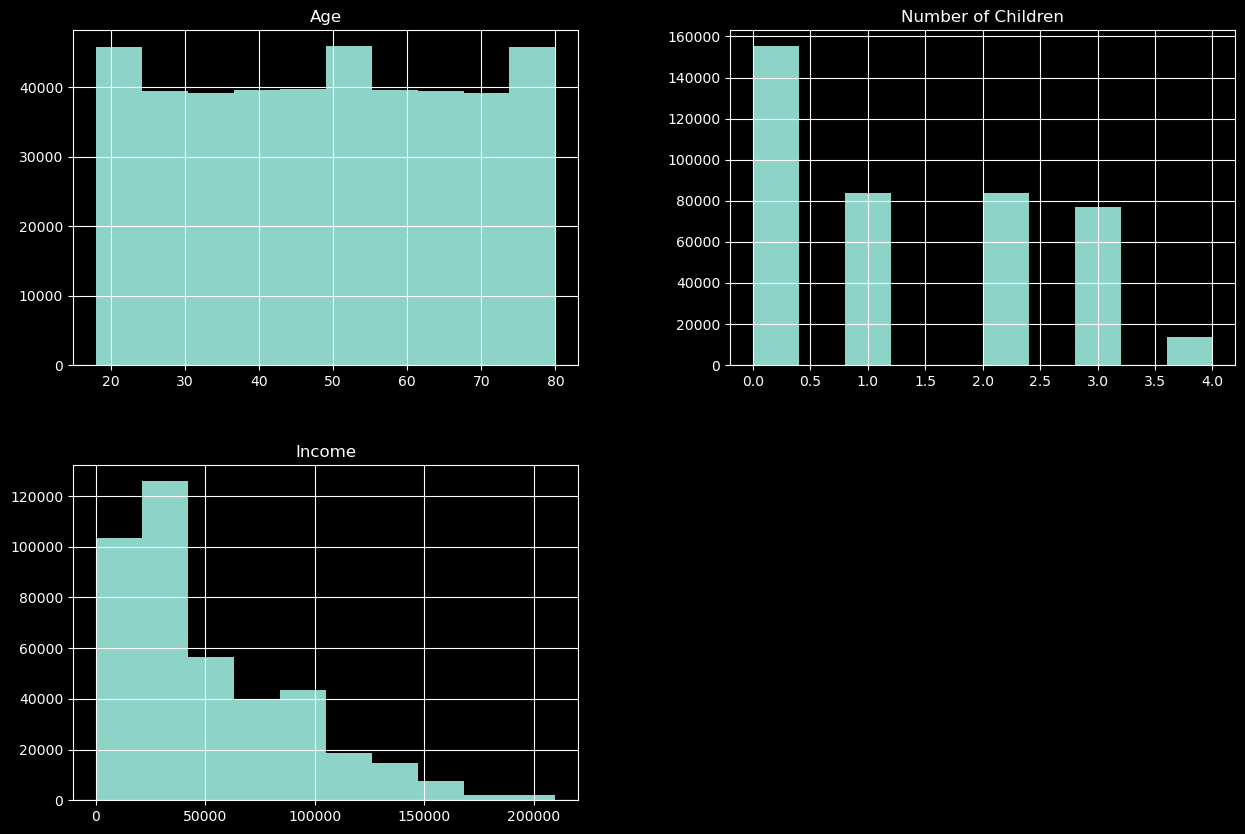

In [84]:
# 수치 데이터 분포
numericList = numericFeature(data)

In [85]:
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,Age,Number of Children,Income
0,0.209677,0.50,0.125076
1,0.596774,0.25,0.203386
2,0.967742,0.25,0.596836
3,0.645161,0.75,0.047584
4,0.000000,0.00,0.040928
...,...,...,...
413763,0.806452,0.00,0.520170
413764,0.129032,0.00,0.460776
413765,0.629032,0.00,0.368356
413766,0.854839,0.50,0.116939


In [86]:
# 문자열 데이터 유니크 확인
getUnique(data)

Marital Status
['Married' 'Widowed' 'Divorced' 'Single']

Education Level
["Bachelor's Degree" 'High School' "Master's Degree" 'Associate Degree'
 'PhD']

Smoking Status
['Non-smoker' 'Former' 'Current']

Physical Activity Level
['Active' 'Sedentary' 'Moderate']

Employment Status
['Unemployed' 'Employed']

Alcohol Consumption
['Moderate' 'High' 'Low']

Dietary Habits
['Moderate' 'Unhealthy' 'Healthy']

Sleep Patterns
['Fair' 'Good' 'Poor']

History of Mental Illness
['Yes' 'No']

History of Substance Abuse
['No' 'Yes']

Family History of Depression
['Yes' 'No']

Chronic Medical Conditions
['Yes' 'No']



In [87]:
# 0에서 1 사이로 인코딩
orderedEncoding(
    data,
    ['History of Mental Illness', 'History of Substance Abuse', 'Family History of Depression'],
    ['No', 'Yes']
)
orderedEncoding(
    data,
    {
        'Marital Status' : ['Widowed', 'Divorced', 'Single', 'Married'],
        'Education Level' : ['High School', 'Associate Degree', "Bachelor's Degree", "Master's Degree", 'PhD'],
        'Smoking Status' : ['Non-smoker', 'Former', "Current"],
        'Physical Activity Level' : ['Sedentary', 'Moderate', "Active"],
        'Employment Status' : ['Unemployed', 'Employed'],
        'Alcohol Consumption' : ['Low', 'Moderate', 'High'],
        'Dietary Habits' : ['Unhealthy', 'Moderate', 'Healthy'],
        'Sleep Patterns' : ['Poor', 'Fair', 'Good']
    }
)

# 정답 데이터 인코딩
answerEncoding(data, 'Chronic Medical Conditions', 'No')

# 결과 보기
data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□

KeyboardInterrupt: 

### 데이터 저장

In [ ]:
data.to_csv("./data/Preprocessed/DataSet6.csv")

## 가설

In [ ]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet6.csv", index_col = "Name")

### 데이터 정보

In [ ]:
data.corr()['Chronic Medical Conditions'].abs().sort_values(ascending = False)

In [ ]:
drawPlot(data, 'Chronic Medical Conditions')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [ ]:
OptKNeighbours(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

In [ ]:
OptDecisionTree(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

In [ ]:
OptRandomForest(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

# 데이터7 (O)

## 전처리

In [82]:
data = pd.read_csv("./data/Depression Professional Dataset.csv")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,Gender,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,37,2.0,4.0,7-8 hours,Moderate,No,6,2,No,No
1,Male,60,4.0,3.0,5-6 hours,Unhealthy,Yes,0,4,Yes,No
2,Female,42,2.0,3.0,5-6 hours,Moderate,No,0,2,No,No
3,Female,44,3.0,5.0,7-8 hours,Healthy,Yes,1,2,Yes,No
4,Male,48,4.0,3.0,7-8 hours,Moderate,Yes,6,5,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
2049,Female,45,1.0,3.0,Less than 5 hours,Healthy,Yes,2,5,Yes,No
2050,Male,25,1.0,5.0,5-6 hours,Healthy,Yes,12,3,Yes,No
2051,Female,23,3.0,1.0,Less than 5 hours,Moderate,Yes,8,3,No,Yes
2052,Female,24,1.0,4.0,Less than 5 hours,Moderate,Yes,4,4,No,No


### 데이터 정보

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 2054 non-null   object 
 1   Age                                    2054 non-null   int64  
 2   Work Pressure                          2054 non-null   float64
 3   Job Satisfaction                       2054 non-null   float64
 4   Sleep Duration                         2054 non-null   object 
 5   Dietary Habits                         2054 non-null   object 
 6   Have you ever had suicidal thoughts ?  2054 non-null   object 
 7   Work Hours                             2054 non-null   int64  
 8   Financial Stress                       2054 non-null   int64  
 9   Family History of Mental Illness       2054 non-null   object 
 10  Depression                             2054 non-null   object 
dtypes: f

### 결측치 확인

In [84]:
data.isnull().sum()

Gender                                   0
Age                                      0
Work Pressure                            0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work Hours                               0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

### 이상치 확인

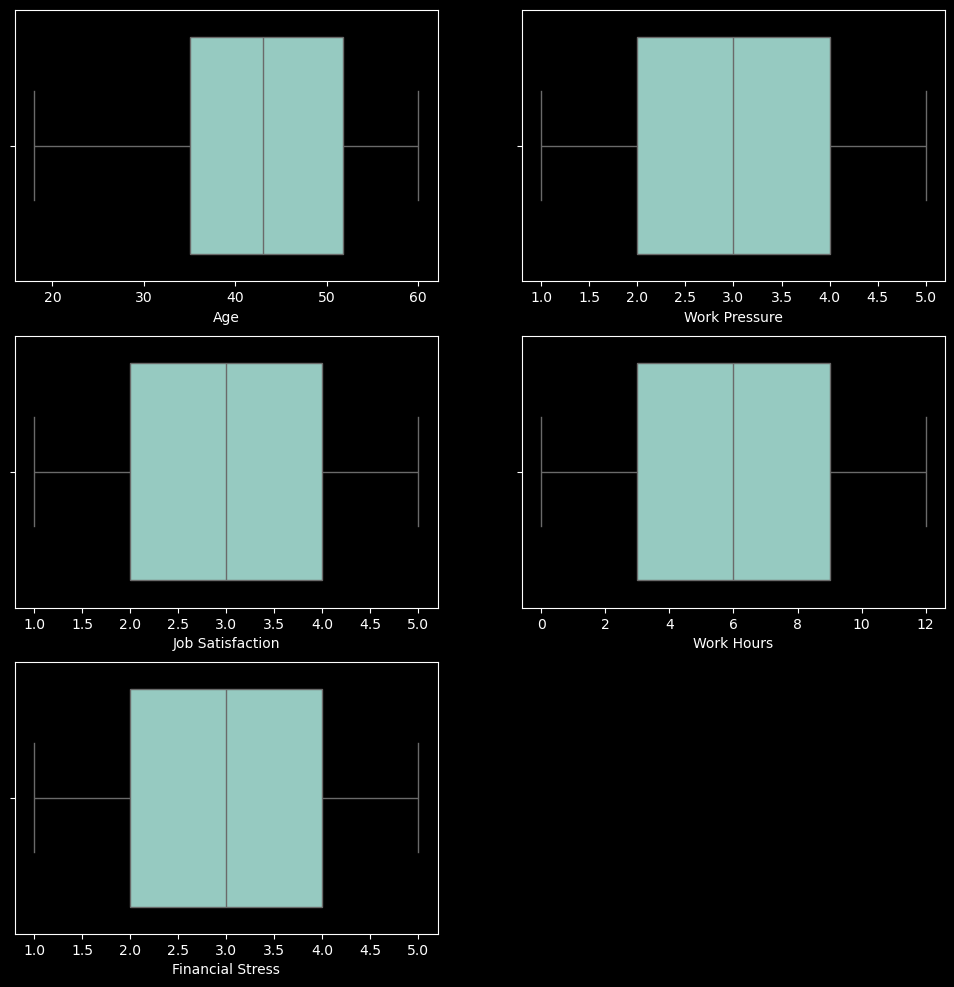

In [85]:
drawBoxPlot(data)

### 인코딩 & 스케일링

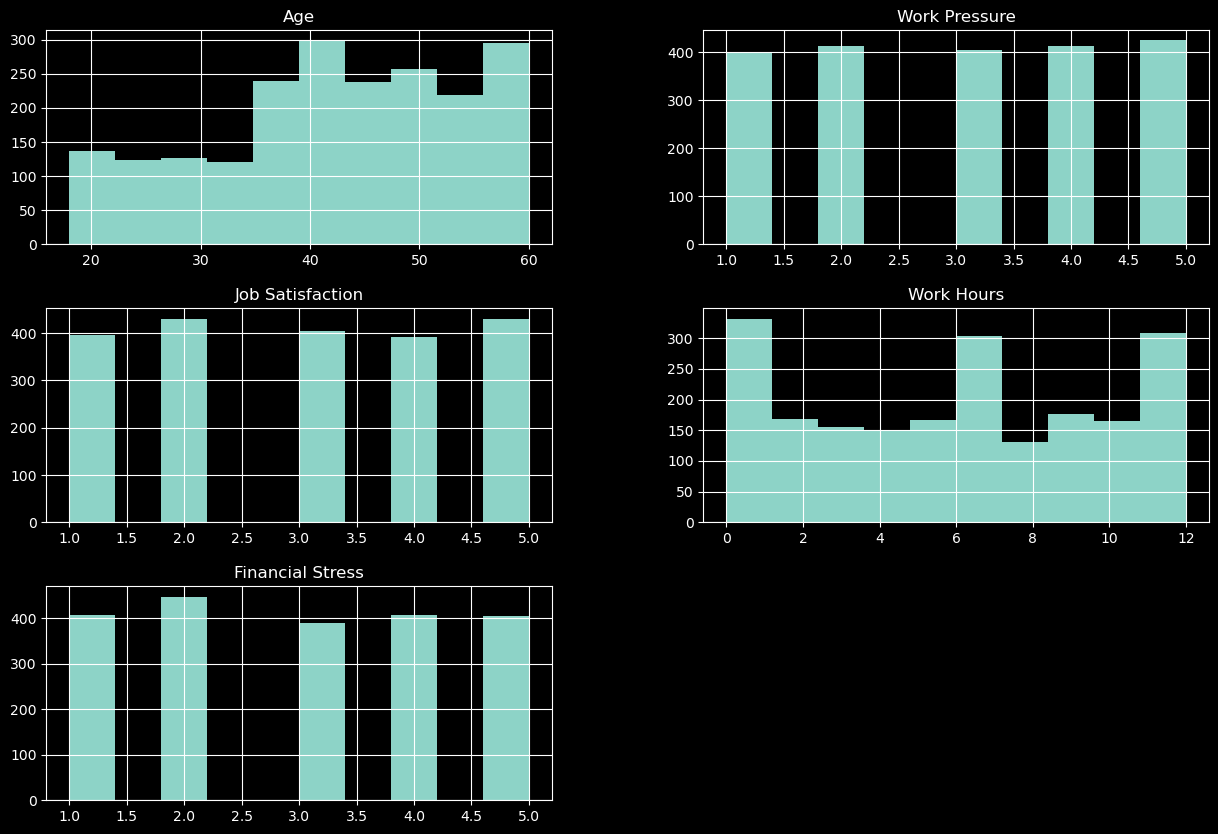

In [86]:
# 수치 데이터 분포
numericList = numericFeature(data)

In [87]:
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,Age,Work Pressure,Job Satisfaction,Work Hours,Financial Stress
0,0.452381,0.25,0.75,0.500000,0.25
1,1.000000,0.75,0.50,0.000000,0.75
2,0.571429,0.25,0.50,0.000000,0.25
3,0.619048,0.50,1.00,0.083333,0.25
4,0.714286,0.75,0.50,0.500000,1.00
...,...,...,...,...,...
2049,0.642857,0.00,0.50,0.166667,1.00
2050,0.166667,0.00,1.00,1.000000,0.50
2051,0.119048,0.50,0.00,0.666667,0.50
2052,0.142857,0.00,0.75,0.333333,0.75


In [88]:
# 문자열 데이터 유니크 확인
getUnique(data)

Gender
['Female' 'Male']

Sleep Duration
['7-8 hours' '5-6 hours' 'More than 8 hours' 'Less than 5 hours']

Dietary Habits
['Moderate' 'Unhealthy' 'Healthy']

Have you ever had suicidal thoughts ?
['No' 'Yes']

Family History of Mental Illness
['No' 'Yes']

Depression
['No' 'Yes']



In [89]:
# 0에서 1 사이 값으로 인코딩
orderedEncoding(
    data,
    ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'],
    ['No', 'Yes']
)
orderedEncoding(
    data,
    {
        'Gender' : ['Male', 'Female'],
        'Sleep Duration' : ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours'],
        'Dietary Habits' : ['Unhealthy', 'Moderate', 'Healthy']
    }
)
answerEncoding(
    data,
    'Depression',
    'No'
)
data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,Gender,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work Hours,Financial Stress,Family History of Mental Illness,Depression
0,1.0,0.452381,0.25,0.75,0.666667,0.5,0.0,0.500000,0.25,0.0,0
1,0.0,1.000000,0.75,0.50,0.333333,0.0,1.0,0.000000,0.75,1.0,0
2,1.0,0.571429,0.25,0.50,0.333333,0.5,0.0,0.000000,0.25,0.0,0
3,1.0,0.619048,0.50,1.00,0.666667,1.0,1.0,0.083333,0.25,1.0,0
4,0.0,0.714286,0.75,0.50,0.666667,0.5,1.0,0.500000,1.00,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2049,1.0,0.642857,0.00,0.50,0.000000,1.0,1.0,0.166667,1.00,1.0,0
2050,0.0,0.166667,0.00,1.00,0.333333,1.0,1.0,1.000000,0.50,1.0,0
2051,1.0,0.119048,0.50,0.00,0.000000,0.5,1.0,0.666667,0.50,0.0,1
2052,1.0,0.142857,0.00,0.75,0.000000,0.5,1.0,0.333333,0.75,0.0,0


### 데이터 저장

In [90]:
data.to_csv("./data/Preprocessed/DataSet7.csv")

## 가설

In [161]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet7.csv").drop("Unnamed: 0", axis = 1)

### 데이터 정보

In [91]:
data.corr()['Depression'].abs().sort_values(ascending = False)

Depression                               1.000000
Age                                      0.421263
Have you ever had suicidal thoughts ?    0.239176
Work Pressure                            0.197509
Job Satisfaction                         0.166880
Financial Stress                         0.151644
Work Hours                               0.128430
Dietary Habits                           0.096727
Sleep Duration                           0.088036
Family History of Mental Illness         0.017549
Gender                                   0.007687
Name: Depression, dtype: float64

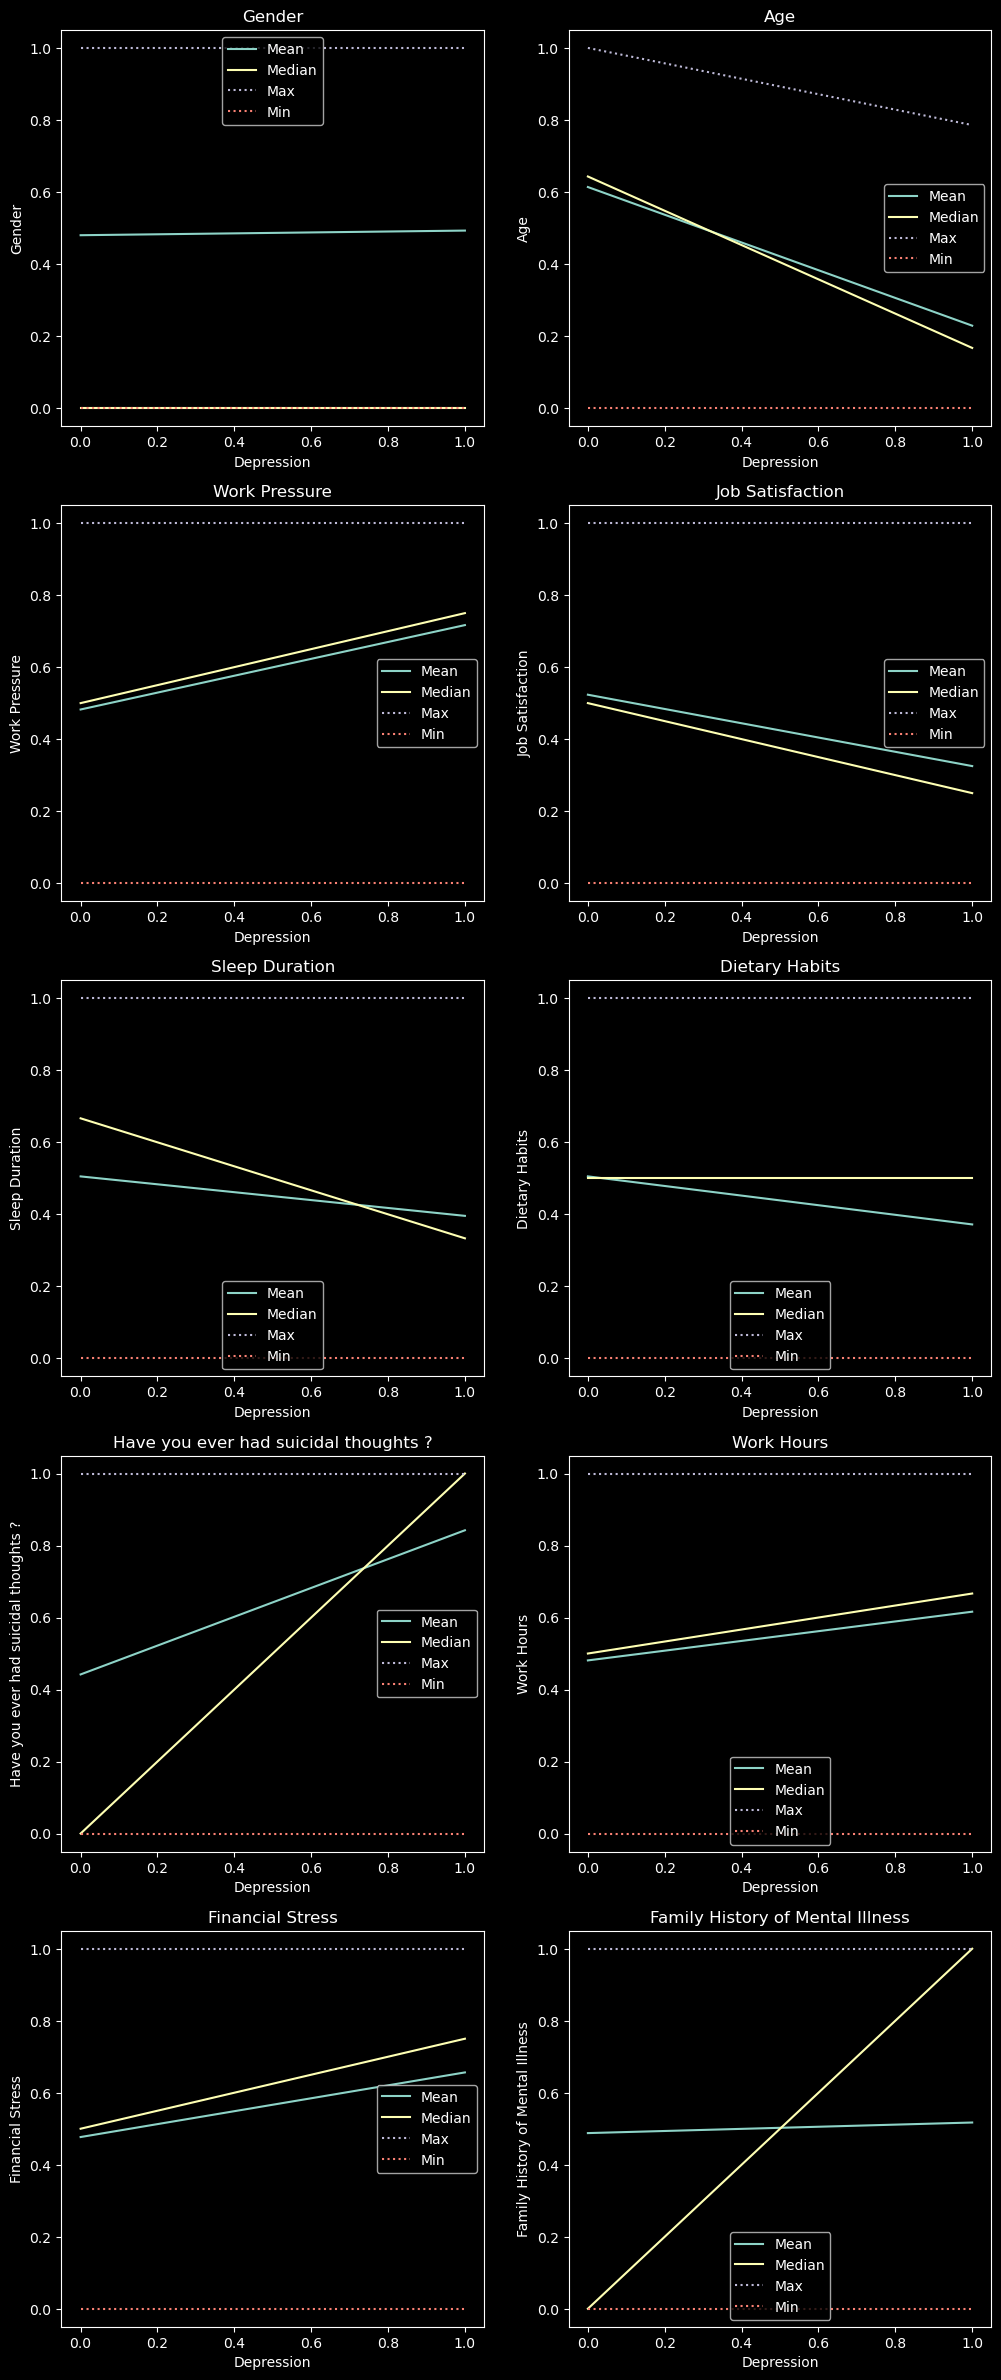

In [92]:
drawPlot(data, 'Depression')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [162]:
OptKNeighbours(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(1437, 10), X_test(617, 10), y_train(1437,), y_test(617,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,이웃 수,정확도,정밀도,재현율
0,3,0.944895,0.843750,0.482143
0,5,0.944895,0.923077,0.428571
0,9,0.943274,0.920000,0.410714
0,7,0.940032,0.880000,0.392857
0,11,0.933549,0.857143,0.321429
0,13,0.933549,0.941176,0.285714
0,15,0.930308,0.933333,0.250000
0,17,0.927066,0.923077,0.214286
0,21,0.923825,1.000000,0.160714
0,19,0.922204,0.900000,0.160714


In [163]:
OptDecisionTree(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

X_train(1437, 10), X_test(617, 10), y_train(1437,), y_test(617,)
■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Prec

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,7,4,8,0.912480,0.515625,0.589286
0,5,7,8,0.915721,0.533333,0.571429
0,7,6,8,0.915721,0.533333,0.571429
0,2,4,4,0.910859,0.507937,0.571429
0,2,4,8,0.910859,0.507937,0.571429
0,2,6,5,0.910859,0.507937,0.571429
0,2,7,7,0.910859,0.507937,0.571429
0,2,8,5,0.910859,0.507937,0.571429
0,7,7,5,0.907618,0.492308,0.571429
0,2,3,5,0.915721,0.534483,0.553571


In [164]:
OptRandomForest(
    data,
    data.columns.drop("Depression"),
    "Depression",
    0.3,
    2025
)

X_train(1437, 10), X_test(617, 10), y_train(1437,), y_test(617,)
□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:39 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:39 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:38 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:38 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:34 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:35 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:35 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:34 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:34 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:33 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:32 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:31 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:30 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:29 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:28 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:28 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:28 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:27 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:27 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:26 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:26 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:26 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:26 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:25 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:25 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:24 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:24 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:24 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:23 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:23 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:23 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:22 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:22 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:21 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:21 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:20 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:20 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:19 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:19 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:18 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:18 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:18 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:17 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:17 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:16 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:15 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:15 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:14 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:14 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:14 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:13 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:13 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:13 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:12 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:11 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:11 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:10 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:10 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:09 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:09 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:09 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□ 0:00:08 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□ 0:00:08 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□ 0:00:07 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□ 0:00:07 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□ 0:00:06 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□ 0:00:05 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□ 0:00:05 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□ 0:00:04 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□ 0:00:04 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□ 0:00:04 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□ 0:00:04 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□ 0:00:03 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□ 0:00:02 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□ 0:00:02 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□ 0:00:01 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□ 0:00:00 

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,6,8,7,0.943274,0.769231,0.535714
0,4,8,8,0.940032,0.731707,0.535714
0,8,7,8,0.940032,0.731707,0.535714
0,8,8,8,0.936791,0.697674,0.535714
0,5,8,8,0.943274,0.783784,0.517857
0,7,6,8,0.943274,0.783784,0.517857
0,6,7,8,0.941653,0.763158,0.517857
0,5,7,7,0.940032,0.743590,0.517857
0,5,8,6,0.940032,0.743590,0.517857
0,7,8,7,0.938412,0.725000,0.517857


# 데이터8

## 전처리

In [96]:
data = pd.read_csv("./data/mental_health_dataset.csv")
data
# 앞으로 원본 데이터는 유지하지 않고 지속적으로 수정할 예정이다.
# 원본 데이터가 필요할 때는 필요할 때만 디스크에서 불러오는 '데이터 드라이브' 방식을 사용한다.

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,34,Female,Employed,On-site,Yes,Yes,5,6.1,3,9,21,8,90.0,Medium
9996,47,Male,Employed,On-site,Yes,No,1,5.7,3,5,12,45,90.8,Medium
9997,56,Female,Employed,On-site,Yes,No,1,8.3,0,1,18,7,99.2,Medium
9998,24,Male,Employed,On-site,Yes,Yes,9,6.1,0,28,21,32,56.7,High


### 데이터 정보

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   gender                  10000 non-null  object 
 2   employment_status       10000 non-null  object 
 3   work_environment        10000 non-null  object 
 4   mental_health_history   10000 non-null  object 
 5   seeks_treatment         10000 non-null  object 
 6   stress_level            10000 non-null  int64  
 7   sleep_hours             10000 non-null  float64
 8   physical_activity_days  10000 non-null  int64  
 9   depression_score        10000 non-null  int64  
 10  anxiety_score           10000 non-null  int64  
 11  social_support_score    10000 non-null  int64  
 12  productivity_score      10000 non-null  float64
 13  mental_health_risk      10000 non-null  object 
dtypes: float64(2), int64(6), object(6)
memo

### 결측치 확인

In [98]:
# 결측치 확인
data.isnull().sum()

age                       0
gender                    0
employment_status         0
work_environment          0
mental_health_history     0
seeks_treatment           0
stress_level              0
sleep_hours               0
physical_activity_days    0
depression_score          0
anxiety_score             0
social_support_score      0
productivity_score        0
mental_health_risk        0
dtype: int64

### 이상치 확인

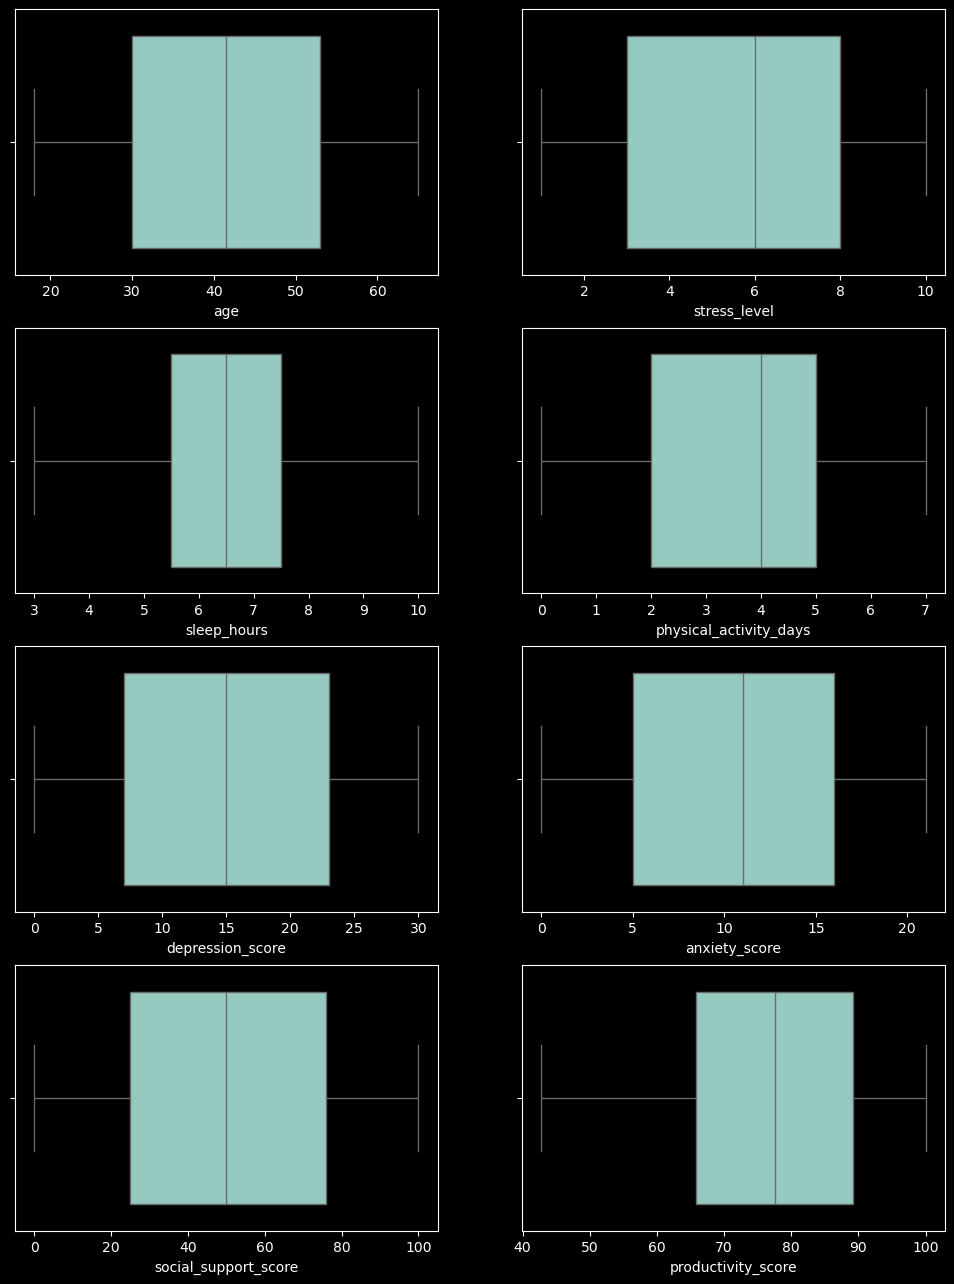

In [99]:
# 이상치 확인
drawBoxPlot(data)

### 인코딩 & 스케일링

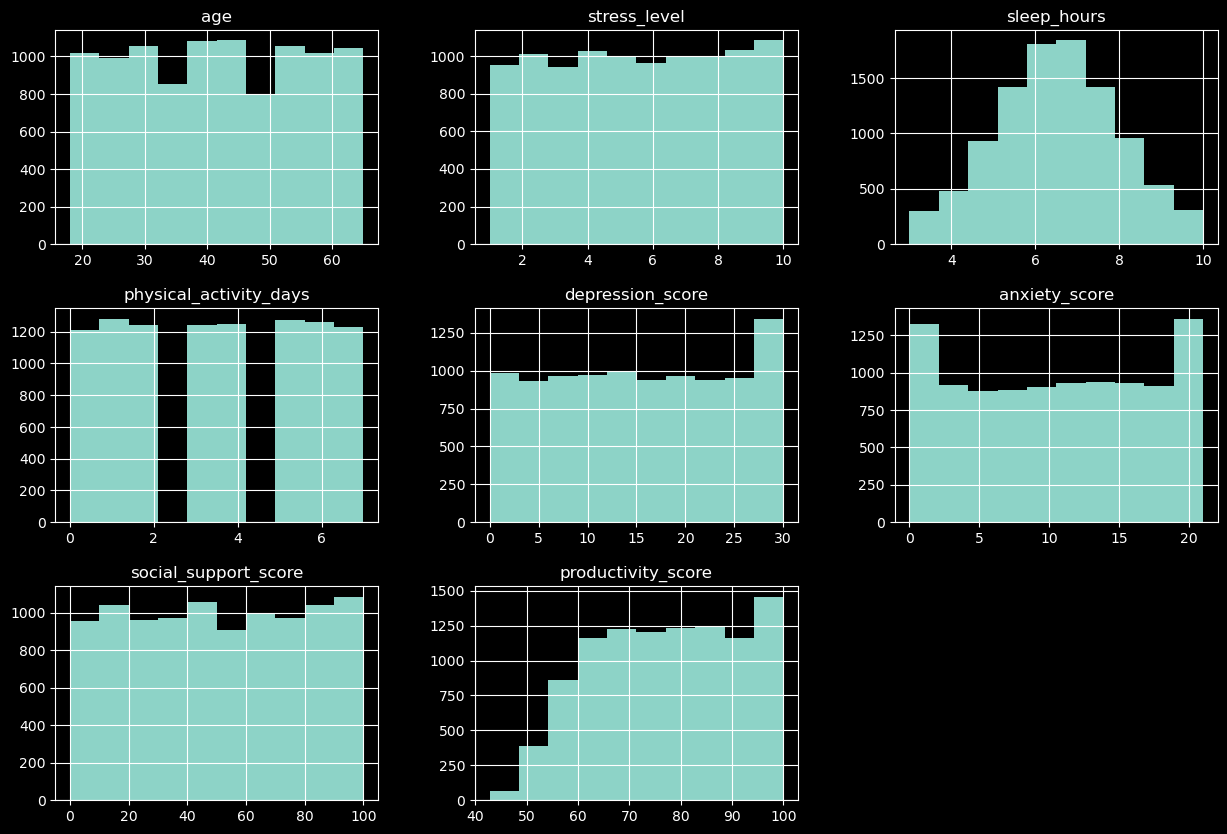

In [100]:
# 수치 데이터 분포
numericList = numericFeature(data)

In [101]:
data[numericList] = MinMaxScaler().fit_transform(data[numericList])
display(data[numericList])

# 불필요한 변수 해제
del numericList

,age,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score
0,0.808511,0.555556,0.457143,0.428571,0.933333,0.809524,0.54,0.295455
1,0.595745,1.000000,0.857143,0.571429,1.000000,0.523810,0.85,0.211538
2,0.297872,0.666667,0.671429,0.285714,0.800000,0.333333,0.62,0.323427
3,0.893617,0.333333,0.214286,0.571429,0.200000,0.000000,0.95,0.947552
4,0.148936,0.222222,0.342857,0.000000,0.800000,0.571429,0.70,0.458042
...,...,...,...,...,...,...,...,...
9995,0.340426,0.444444,0.442857,0.428571,0.300000,1.000000,0.08,0.825175
9996,0.617021,0.000000,0.385714,0.428571,0.166667,0.571429,0.45,0.839161
9997,0.808511,0.000000,0.757143,0.000000,0.033333,0.857143,0.07,0.986014
9998,0.127660,0.888889,0.442857,0.000000,0.933333,1.000000,0.32,0.243007


In [102]:
# 문자열 데이터 유니크 확인
getUnique(data)

gender
['Male' 'Female' 'Non-binary' 'Prefer not to say']

employment_status
['Employed' 'Student' 'Self-employed' 'Unemployed']

work_environment
['On-site' 'Remote' 'Hybrid']

mental_health_history
['Yes' 'No']

seeks_treatment
['Yes' 'No']

mental_health_risk
['High' 'Medium' 'Low']



In [103]:
# 불필요해보이는 데이터 추가 제거
# 성별을 응답하지 않은 데이터가 그대로 있다는 것은 성별 정보가 중요하지 않다는 것을 의미.
data.drop('gender', axis = 1, inplace = True)

In [104]:
# 0에서 1 사이로 인코딩
orderedEncoding(
    data,
    [
        'mental_health_history', 'seeks_treatment'
    ],
    ['No', 'Yes']
)
orderedEncoding(
    data,
    {
        'work_environment' : ['On-site', 'Hybrid', 'Remote']
    }
)
answerEncoding(
    data,
    'mental_health_risk',
    'Low'
)
# employment_status는 순서를 주기 어려워서 원핫인코딩한다.
data = pd.get_dummies(data, dtype = 'int64')

data

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□ 0:00:01 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□□□□□□□□ 0:00:00 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### 데이터 저장

In [105]:
data.to_csv("./data/Preprocessed/DataSet8.csv")

## 가설

In [165]:
# 전처리된 데이터 불러오기
data = pd.read_csv("./data/Preprocessed/DataSet8.csv").drop("Unnamed: 0", axis = 1)

### 데이터 정보

In [106]:
# 상관계수
data.corr()['mental_health_risk'].abs().sort_values(ascending = False)

mental_health_risk                 1.000000
depression_score                   0.528658
productivity_score                 0.492862
anxiety_score                      0.433415
employment_status_Self-employed    0.015761
work_environment                   0.015430
age                                0.015057
sleep_hours                        0.009317
employment_status_Unemployed       0.009104
seeks_treatment                    0.008883
stress_level                       0.006278
physical_activity_days             0.005385
employment_status_Student          0.002799
employment_status_Employed         0.001846
social_support_score               0.001519
mental_health_history              0.001096
Name: mental_health_risk, dtype: float64

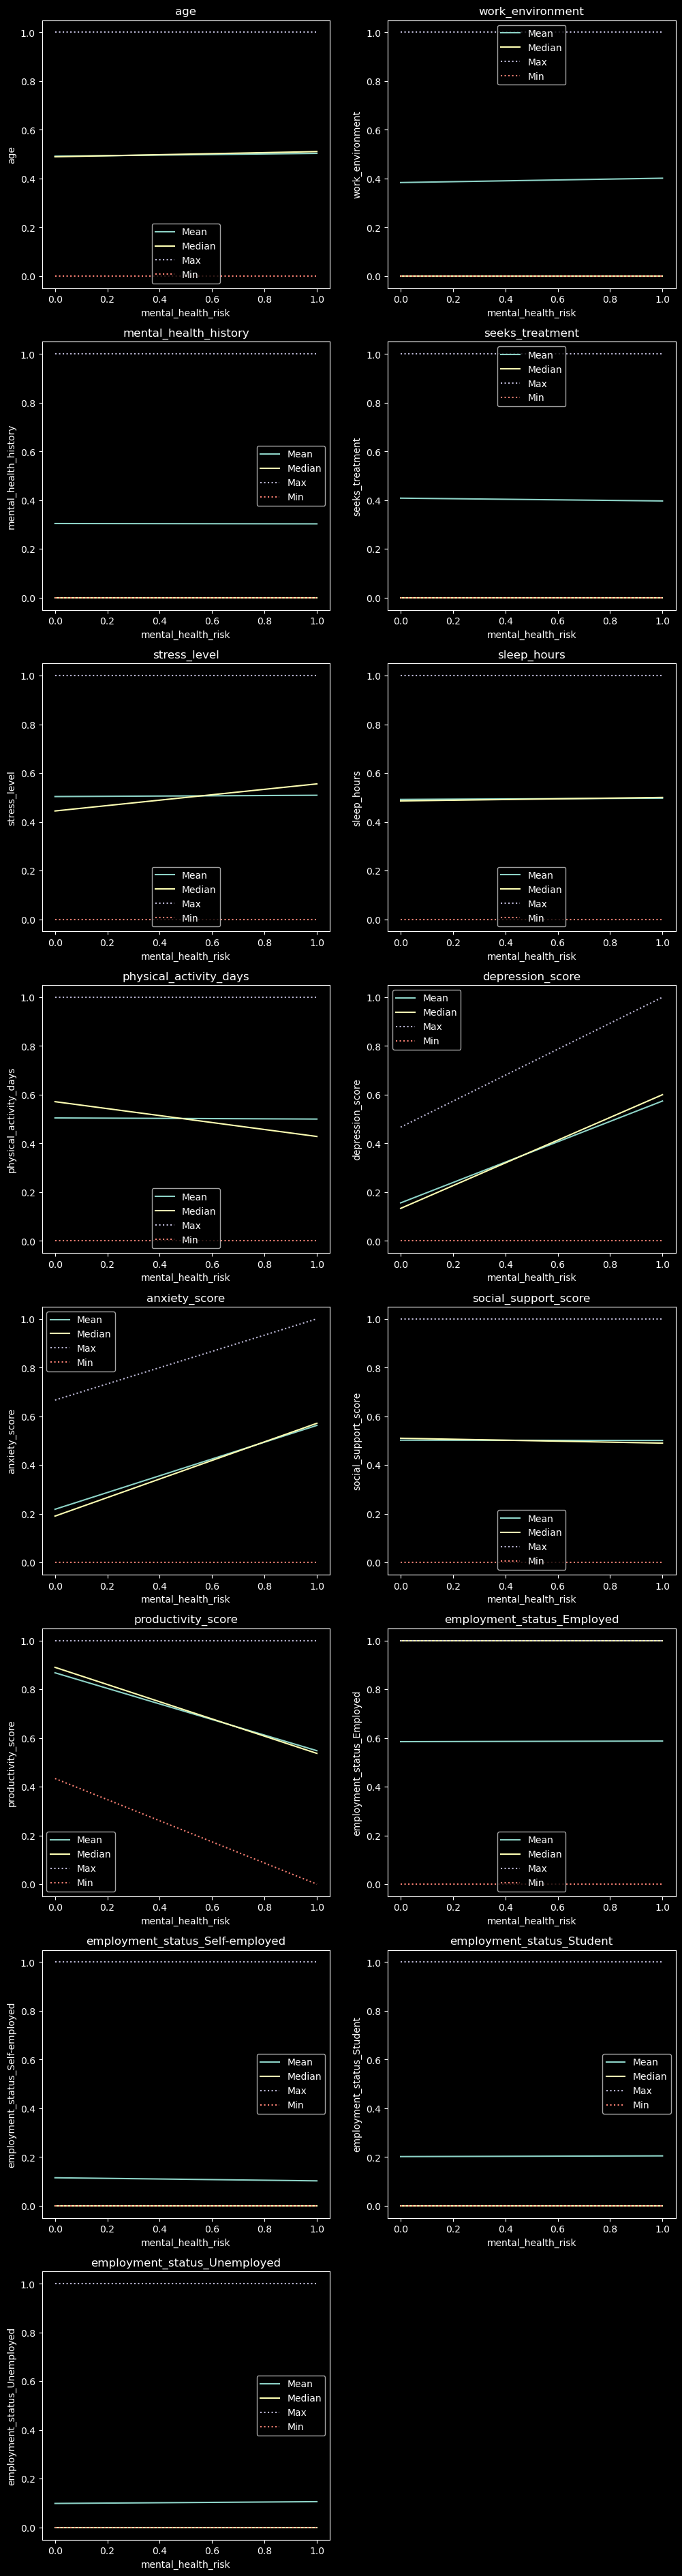

In [107]:
drawPlot(data, 'mental_health_risk')

### 가설1
- 모든 컬럼이 정신질환에 영향을 줄 것이다.

In [167]:
OptKNeighbours(
    data,
    data.columns.drop("mental_health_risk"),
    "mental_health_risk",
    0.3,
    2025
)

X_train(7000, 15), X_test(3000, 15), y_train(7000,), y_test(3000,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,이웃 수,정확도,정밀도,재현율
0,59,0.881000,0.874071,0.999595
0,61,0.877667,0.870990,0.999595
0,63,0.875000,0.868541,0.999595
0,65,0.874000,0.867626,0.999595
0,67,0.872000,0.865802,0.999595
0,69,0.871000,0.864893,0.999595
0,71,0.870000,0.863986,0.999595
0,73,0.869000,0.863081,0.999595
0,75,0.868000,0.862177,0.999595
0,77,0.864667,0.859179,0.999595


In [168]:
OptDecisionTree(
    data,
    data.columns.drop("mental_health_risk"),
    "mental_health_risk",
    0.3,
    2025
)

X_train(7000, 15), X_test(3000, 15), y_train(7000,), y_test(3000,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,4,2,6,0.825000,0.824825,1.0
0,7,1,8,0.824667,0.824550,1.0
0,1,1,2,0.824000,0.824000,1.0
0,1,1,3,0.824000,0.824000,1.0
0,1,1,4,0.824000,0.824000,1.0
0,1,1,5,0.824000,0.824000,1.0
0,1,1,6,0.824000,0.824000,1.0
0,1,1,7,0.824000,0.824000,1.0
0,1,1,8,0.824000,0.824000,1.0
0,1,2,2,0.824000,0.824000,1.0


In [169]:
OptRandomForest(
    data,
    data.columns.drop("mental_health_risk"),
    "mental_health_risk",
    0.3,
    2025
)

X_train(7000, 15), X_test(3000, 15), y_train(7000,), y_test(3000,)
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0:00:00 


,max_depth,max_features,max_leaf_nodes,정확도,정밀도,재현율
0,6,4,7,0.948667,0.941356,1.0
0,4,4,6,0.940000,0.932127,1.0
0,5,3,8,0.939667,0.931775,1.0
0,7,3,8,0.939667,0.931775,1.0
0,4,4,5,0.936333,0.928276,1.0
0,5,3,7,0.929333,0.921013,1.0
0,4,3,7,0.928667,0.920328,1.0
0,8,4,4,0.927667,0.919301,1.0
0,8,3,8,0.927333,0.918959,1.0
0,6,3,7,0.923667,0.915217,1.0
